In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
import argparse
import math
from scipy import stats
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc

sys.path.insert(0, '..')

from util.xai import gradcam, interpolate_expl_matrix, plot_matrix
from config import *
from models.nt_classifier import build as build_model 
from util.plot_utils import balance_df, obtain_plot, plot_logs, collect_results_based_on_confidence_level_based_on_treshold, plot_confs_and_accs, collect_prec_recall_sens_npv_based_on_confidence_level_based_on_percentile, collect_prec_recall_sens_npv_based_on_confidence_level_based_on_treshold, calc_acc_for_each_class, plot_roc_curves, collect_results_based_on_confidence_level_how_many1, acc_for_each_class
from util.plot_utils import collect_results_based_on_confidence_level_based_on_percentile as collect_results_based_on_confidence_level
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

<class 'transformers.tokenization_dna.DNATokenizer'>


In [3]:
how = 'ricseq'

only_test = False
exclude_train_genes = False
exclude_paris_genes = False
exclude_paris_couples = True

filter_hq_ricseq = False

MIN_N_READS_RICSEQ = 3

In [4]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', 'all_modelarch2_easypretrain11_paristfinetuningsplashRICSEQval0054') 
#all_modelarch2_easypretrain11_paristfinetuningSPLASHval0061


In [5]:
res = pd.read_csv(os.path.join(checkpoint_dir, f'{how}_results500.csv'))

In [6]:
if (how == 'ricseq')&filter_hq_ricseq:
    ricsechq = pd.read_csv(os.path.join(os.path.join('ricseqHQ_couples.csv')))
    hq = res[res.couples.isin(ricsechq['couples'])]
    pos_to_keep = list(hq[hq.policy == 'easypos'].id_sample)
    smartneg_to_drop = list(hq[hq.policy == 'smartneg'].id_sample)
    res = res[
        (res.id_sample.isin(pos_to_keep)) | 
        ((res.policy == 'smartneg') & (~res.id_sample.isin(smartneg_to_drop)) ) | 
        ((res.policy == 'hardneg') & (res.id_sample.isin(pos_to_keep)) ) |
        ((res.policy == 'easyneg') & (~res.id_sample.isin(smartneg_to_drop)) )
    ]

In [7]:
file_train = os.path.join(rna_rna_files_dir, f'{how}', 'gene_pairs_training.txt')
with open(file_train, "rb") as fp:   # Unpickling
    train_couples = pickle.load(fp)
    
file_test = os.path.join(rna_rna_files_dir, f'{how}', 'gene_pairs_test.txt')
with open(file_test, "rb") as fp:   # Unpickling
    test_couples = pickle.load(fp)
    
train_paris = os.path.join(rna_rna_files_dir, 'gene_pairs_training.txt')
with open(train_paris, "rb") as fp:   # Unpickling
    paris_couples1 = pickle.load(fp)
val_paris = os.path.join(rna_rna_files_dir, 'gene_pairs_val.txt')
with open(val_paris, "rb") as fp:   # Unpickling
    paris_couples2 = pickle.load(fp)

paris_couples=pd.Series(list(set(paris_couples1).union(paris_couples2))).str.extractall('(.*)_(.*)').reset_index()
paris_genes = set(paris_couples[0]).union(paris_couples[1])    
paris_couples = set(paris_couples1).union(paris_couples2)

    
tr_genes=pd.Series(train_couples).str.extractall('(.*)_(.*)').reset_index()
training_genes = set(tr_genes[0]).union(tr_genes[1])

if only_test:
    res = res[res.couples.isin(test_couples)]
    if exclude_train_genes:
        res = res[~(res.gene1_original.isin(training_genes) | res.gene2_original.isin(training_genes))]
        
if exclude_paris_genes:
    n_original_couples=res.shape[0]
    res = res[~(res.gene1_original.isin(paris_genes) | res.gene2_original.isin(paris_genes))]
    print('# excluded couples: ', n_original_couples - res.shape[0])
if exclude_paris_couples:
    n_original_couples=res.shape[0]
    res = res[~(res.couples.isin(paris_couples))]
    print('# excluded couples: ', n_original_couples - res.shape[0])

# excluded couples:  244


In [8]:
test500 = pd.read_csv(os.path.join(metadata_dir, f'{how}500.csv'))
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_{how}.csv'))

assert test500.shape[0] == df_nt[['couples', 'interacting', 'policy']].merge(test500, on = 'couples').shape[0]

if how == 'ricseq':
    test500 = df_nt[['couples', 'interacting', 'policy', 'where', 'where_x1', 'where_y1', 'simple_repeats', 'sine_alu', 'low_complex', 'n_reads']].merge(test500, on = 'couples')
    ids_to_keep = set(test500[test500.n_reads >= MIN_N_READS_RICSEQ].couples).union(test500[test500.interacting==False].couples)
    res = res[res.id_sample.isin(ids_to_keep)]
elif how == 'mario':
    test500 = df_nt[['couples', 'interacting', 'policy', 'where', 'where_x1', 'where_y1', 'simple_repeats', 'sine_alu', 'low_complex', 'n_reads']].merge(test500, on = 'couples')
elif how == 'splash':
    test500 = df_nt[['couples', 'interacting', 'policy', 'where', 'where_x1', 'where_y1', 'experiment']].merge(test500, on = 'couples')
else:
    raise NotImplementedError
    
id_cds_cds = set(test500[test500['where'] == 'CDS-CDS'].couples)

In [9]:
intarna = pd.read_csv(os.path.join(intarna_dir, f'{how}500_RANDOM', f'{how}.csv'), sep = ';')
intarna['key'] = intarna.id1 + '_' + intarna.id2

# keep only the lower E_norm for each group
intarna.sort_values('E_norm', ascending = False, inplace=True)
intarna.drop_duplicates(subset='key', keep='first', inplace=True)
intarna = intarna.reset_index(drop = True)
intarna['couples'] = intarna.id1.str.extractall('(.*)_(.*)').reset_index(drop = True)[0]
intarna['couples'] = intarna['couples'].astype(int)

intarna = intarna.dropna()


res = res.merge(intarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample')

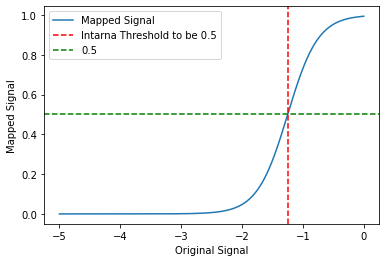

In [10]:
intarna_treshold = -1.25

def custom_sigmoid(x, slope_at_origin=2):
    return 0.5 + 0.5 * np.tanh(x * slope_at_origin)

def map_signal_to_sigmoid_range(signal, threshold):
    mapped_signal = custom_sigmoid((signal - threshold))
    return mapped_signal

# Example usage
signal_range = np.linspace(-5, 0, 1000)

mapped_signal = map_signal_to_sigmoid_range(signal_range, intarna_treshold)

# Plotting the results
plt.plot(signal_range, mapped_signal, label='Mapped Signal')
plt.axvline(x=intarna_treshold, color='r', linestyle='--', label='Intarna Threshold to be 0.5')
plt.axhline(y=0.5, color='g', linestyle='--', label='0.5')
plt.xlabel('Original Signal')
plt.ylabel('Mapped Signal')
plt.legend()
plt.show()

# Ranking the 'E_norm' column in ascending order
res['E_norm_conf'] = map_signal_to_sigmoid_range(res['E_norm'], intarna_treshold)
res['E_norm_conf'] = 1 - res['E_norm_conf']

### L agreement score in questo caso di intarna non tiene conto dello sbilanciamento dei dati... dovrei prima trovare qual e l la soglia di INTARNA dove mettere lo 0.5 e poi fare la media con lo score del nostro modello
res['ensemble_score'] = (res['probability'] + res['E_norm_conf']) / 2
assert res.ensemble_score.max() <= 1
assert res.ensemble_score.min() >= 0

In [11]:
# exclude the common genes
# gene_count = pd.concat([res.gene1_original, res.gene2_original]).value_counts()
# rare_genes = list(gene_count[gene_count<20].index)
# res = res[res.gene1_original.isin(rare_genes) & res.gene2_original.isin(rare_genes)]

# Depend on the length?

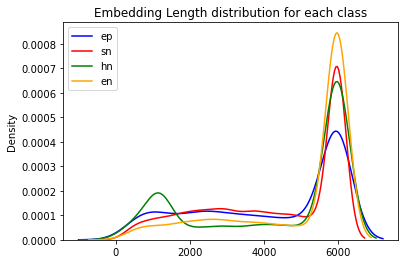

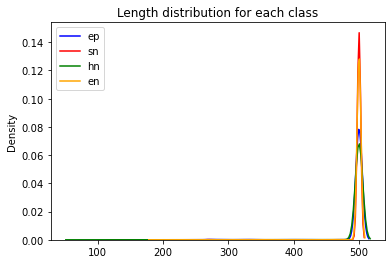

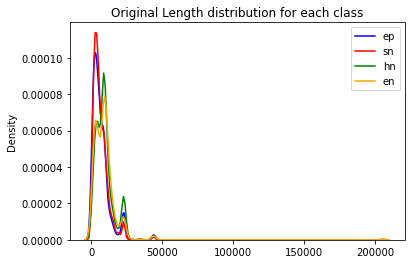

In [12]:
len_emb1 = res.g1.str.extractall('(.*)_(.*)_(.*)').reset_index(drop = True)
len_emb2 = res.g2.str.extractall('(.*)_(.*)_(.*)').reset_index(drop = True)
res['len_emb1'] = len_emb1[2].astype(int) - len_emb1[1].astype(int)
res['len_emb2'] = len_emb2[2].astype(int) - len_emb2[1].astype(int)

ep_len = list(res[res.policy == 'easypos'].len_emb1) + list(res[res.policy == 'easypos'].len_emb2)
sn_len = list(res[res.policy == 'smartneg'].len_emb1) + list(res[res.policy == 'smartneg'].len_emb2)
hn_len = list(res[res.policy == 'hardneg'].len_emb1) + list(res[res.policy == 'hardneg'].len_emb2)
en_len = list(res[res.policy == 'easyneg'].len_emb1) + list(res[res.policy == 'easyneg'].len_emb2)

sns.kdeplot(ep_len, label = 'ep', color = 'b')
sns.kdeplot(sn_len, label = 'sn', color = 'r')
sns.kdeplot(hn_len, label = 'hn', color = 'g')
sns.kdeplot(en_len, label = 'en', color = 'orange')
plt.title(f'Embedding Length distribution for each class')
plt.legend()
plt.show()


ep_len = list(res[res.policy == 'easypos'].len_g1) + list(res[res.policy == 'easypos'].len_g2)
sn_len = list(res[res.policy == 'smartneg'].len_g1) + list(res[res.policy == 'smartneg'].len_g2)
hn_len = list(res[res.policy == 'hardneg'].len_g1) + list(res[res.policy == 'hardneg'].len_g2)
en_len = list(res[res.policy == 'easyneg'].len_g1) + list(res[res.policy == 'easyneg'].len_g2)

sns.kdeplot(ep_len, label = 'ep', color = 'b')
sns.kdeplot(sn_len, label = 'sn', color = 'r')
sns.kdeplot(hn_len, label = 'hn', color = 'g')
sns.kdeplot(en_len, label = 'en', color = 'orange')
plt.title(f'Length distribution for each class')
plt.legend()
plt.show()


ep_len = list(res[res.policy == 'easypos'].original_length1) + list(res[res.policy == 'easypos'].original_length2)
sn_len = list(res[res.policy == 'smartneg'].original_length1) + list(res[res.policy == 'smartneg'].original_length2)
hn_len = list(res[res.policy == 'hardneg'].original_length1) + list(res[res.policy == 'hardneg'].original_length2)
en_len = list(res[res.policy == 'easyneg'].original_length1) + list(res[res.policy == 'easyneg'].original_length2)

sns.kdeplot(ep_len, label = 'ep', color = 'b')
sns.kdeplot(sn_len, label = 'sn', color = 'r')
sns.kdeplot(hn_len, label = 'hn', color = 'g')
sns.kdeplot(en_len, label = 'en', color = 'orange')
plt.title(f'Original Length distribution for each class')
plt.legend()
plt.show()

<AxesSubplot:>

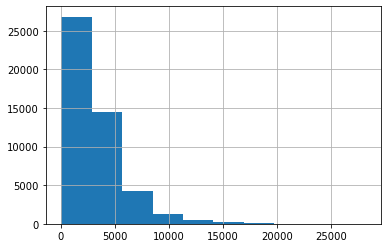

In [13]:
df_genes = pd.read_csv(os.path.join(processed_files_dir, f'df_genes.csv'))
df = pd.read_csv(os.path.join(processed_files_dir, f'{how}.csv'))
df_genes[df_genes.length < 30_000].length.hist()

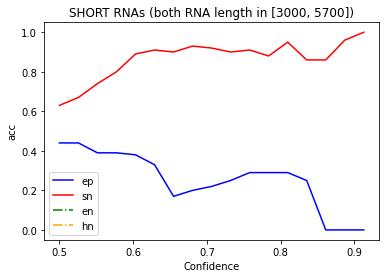

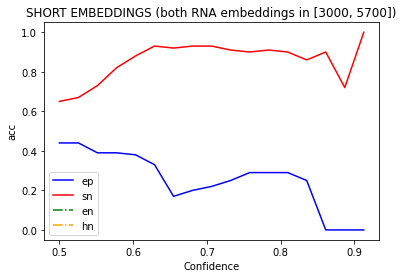

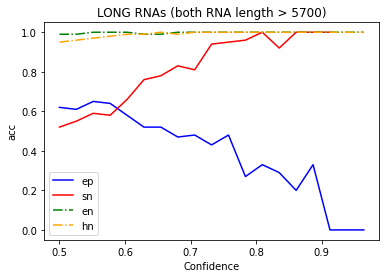

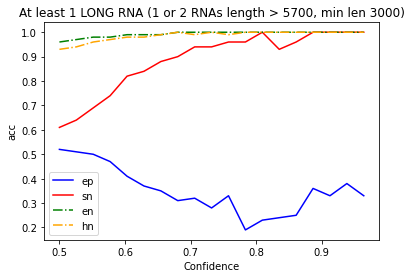

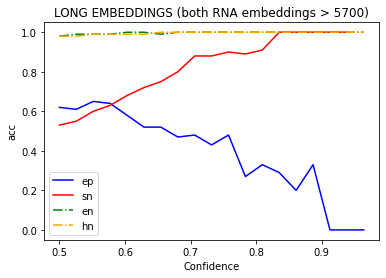

In [14]:
treshold = 5_700
min_len_both_rna = 3_000


conf_space = np.linspace(0.5, 0.99, 20)


# ---------------------------------------    

eps = []
sns = []
ens = []
hns = []
confs = []

for conf_level in conf_space:

    shorts = res[(res.original_length1 < treshold) & (res.original_length2 < treshold)]
    shorts = shorts[(shorts.original_length1 > min_len_both_rna) & (shorts.original_length2 > min_len_both_rna)]
    shorts = shorts[(shorts.probability > conf_level) | (shorts.probability < 1-conf_level)]
    shorts = balance_df(shorts)
    acc_ep, acc_sn, acc_en, acc_hn = calc_acc_for_each_class(shorts)
    eps.append(acc_ep)
    sns.append(acc_sn)
    ens.append(acc_en)
    hns.append(acc_hn)
    confs.append(conf_level)
    #assert False

plot_confs_and_accs(eps, sns, ens, hns, confs, f"SHORT RNAs (both RNA length in [{min_len_both_rna}, {treshold}])")

# ---------------------------------------    

eps = []
sns = []
ens = []
hns = []
confs = []

for conf_level in conf_space:

    short_emb = res[(res.len_emb1 < treshold) & (res.len_emb2 < treshold)]
    short_emb = short_emb[(short_emb.len_emb1 > min_len_both_rna) & (short_emb.len_emb2 > min_len_both_rna)]
    short_emb = short_emb[(short_emb.probability > conf_level) | (short_emb.probability < 1-conf_level)]
    short_emb = balance_df(short_emb)
    acc_ep, acc_sn, acc_en, acc_hn = calc_acc_for_each_class(short_emb)
    eps.append(acc_ep)
    sns.append(acc_sn)
    ens.append(acc_en)
    hns.append(acc_hn)
    confs.append(conf_level)

plot_confs_and_accs(eps, sns, ens, hns, confs, f"SHORT EMBEDDINGS (both RNA embeddings in [{min_len_both_rna}, {treshold}])")

# ---------------------------------------  

eps = []
sns = []
ens = []
hns = []
confs = []

for conf_level in conf_space:

    long = res[(res.original_length1 > treshold) & (res.original_length2 > treshold)]
    long = long[(long.probability > conf_level) | (long.probability < 1-conf_level)]
    long = balance_df(long)
    acc_ep, acc_sn, acc_en, acc_hn = calc_acc_for_each_class(long)
    eps.append(acc_ep)
    sns.append(acc_sn)
    ens.append(acc_en)
    hns.append(acc_hn)
    confs.append(conf_level)
    
plot_confs_and_accs(eps, sns, ens, hns, confs,f"LONG RNAs (both RNA length > {treshold})")

# ---------------------------------------  

eps = []
sns = []
ens = []
hns = []
confs = []

for conf_level in conf_space:

    long = res[(res.original_length1 > treshold) | (res.original_length2 > treshold)]
    long = long[(long.original_length1 > min_len_both_rna) & (long.original_length2 > min_len_both_rna)]
    long = long[(long.probability > conf_level) | (long.probability < 1-conf_level)]
    long = balance_df(long)
    acc_ep, acc_sn, acc_en, acc_hn = calc_acc_for_each_class(long)
    eps.append(acc_ep)
    sns.append(acc_sn)
    ens.append(acc_en)
    hns.append(acc_hn)
    confs.append(conf_level)
    
plot_confs_and_accs(eps, sns, ens, hns, confs,f"At least 1 LONG RNA (1 or 2 RNAs length > {treshold}, min len {min_len_both_rna})")

# ---------------------------------------  

eps = []
sns = []
ens = []
hns = []
confs = []

for conf_level in conf_space:

    long_emb = res[(res.len_emb1 > treshold) & (res.len_emb2 > treshold)]
    long_emb = long_emb[(long_emb.probability > conf_level) | (long_emb.probability < 1-conf_level)]
    long_emb = balance_df(long_emb)
    acc_ep, acc_sn, acc_en, acc_hn = calc_acc_for_each_class(long_emb)
    eps.append(acc_ep)
    sns.append(acc_sn)
    ens.append(acc_en)
    hns.append(acc_hn)
    confs.append(conf_level)

plot_confs_and_accs(eps, sns, ens, hns, confs,f"LONG EMBEDDINGS (both RNA embeddings > {treshold})")

In [15]:
conf_level = 0.8
shorts = res[(res.original_length1 < treshold) & (res.original_length2 < treshold)]
shorts = shorts[(shorts.original_length1 > min_len_both_rna) & (shorts.original_length2 > min_len_both_rna)]
shorts = shorts[(shorts.probability > conf_level) | (shorts.probability < 1-conf_level)]
shorts = balance_df(shorts)

In [16]:
from util.plot_utils import calc_prec_rec_sens_npv

In [17]:
calc_prec_rec_sens_npv(shorts, 'probability')

(0.76, 0.29, 0.91, 0.56)

In [18]:
tp = shorts[(shorts.ground_truth == 1) & (shorts.probability > 0.5)].shape[0]
fn = shorts[(shorts.ground_truth == 1) & (shorts.probability < 0.5)].shape[0]
fp = shorts[(shorts.ground_truth == 0) & (shorts.probability > 0.5)].shape[0]
tn = shorts[(shorts.ground_truth == 0) & (shorts.probability < 0.5)].shape[0]

In [19]:
prec = tp/(fp + tp)
rec = tp/(fn + tp)

In [20]:
prec, rec

(0.7575757575757576, 0.2857142857142857)

### Based on top-bottom

area interval: [0, 1303316]
percentile:  10.0
# data:  309
perc_pos_predicted:  60.0
smartneg    218
easypos      91
Name: policy, dtype: int64


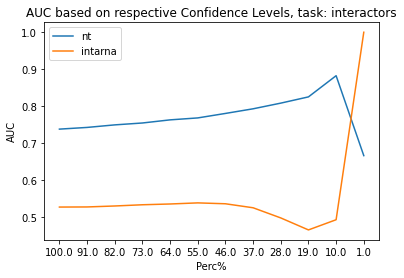

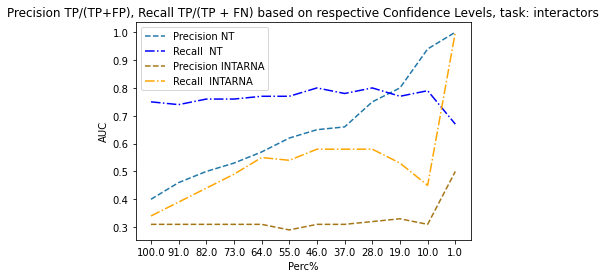



area interval: [1303316, 4029408]
percentile:  19.0
# data:  783
perc_pos_predicted:  60.0
smartneg    710
easypos      73
Name: policy, dtype: int64


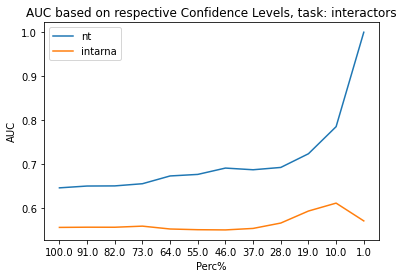

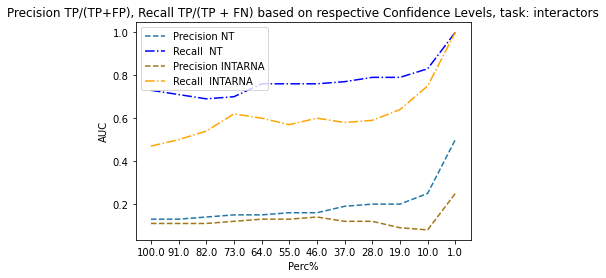



area interval: [4029408, 6975886]
percentile:  28.0
# data:  906
perc_pos_predicted:  56.99999999999999
smartneg    826
easypos      80
Name: policy, dtype: int64


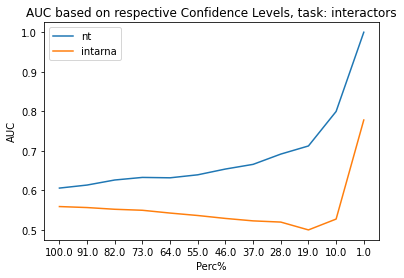

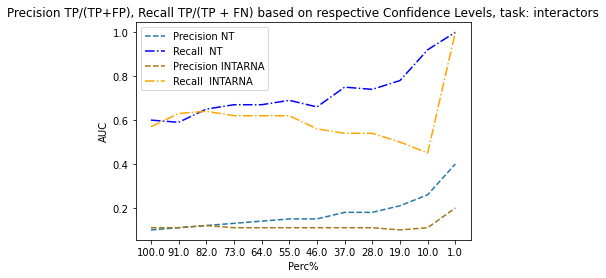



area interval: [6975886, 11303460]
percentile:  37.0
# data:  1232
perc_pos_predicted:  53.0
smartneg    1141
easypos       91
Name: policy, dtype: int64


/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false po

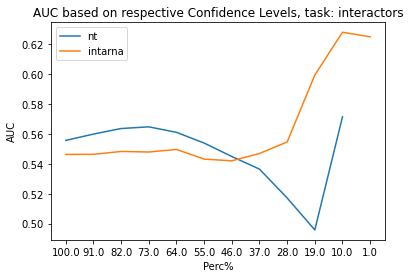

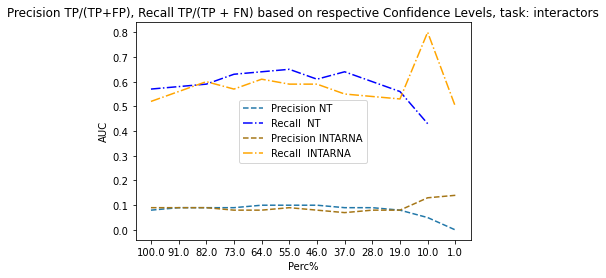



area interval: [11303460, 14905805]
percentile:  46.0
# data:  869
perc_pos_predicted:  52.0
smartneg    766
easypos     103
Name: policy, dtype: int64


/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


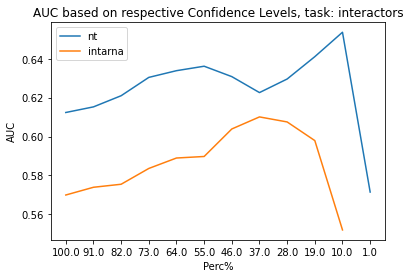

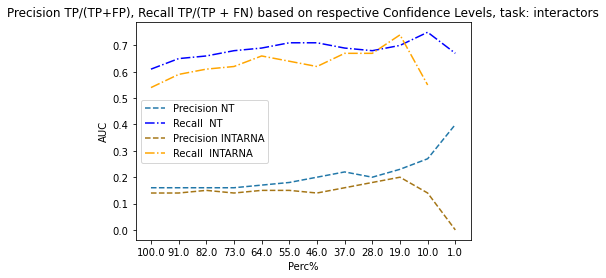



area interval: [14905805, 21756648]
percentile:  55.0
# data:  1463
perc_pos_predicted:  43.0
smartneg    1351
easypos      112
Name: policy, dtype: int64


/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


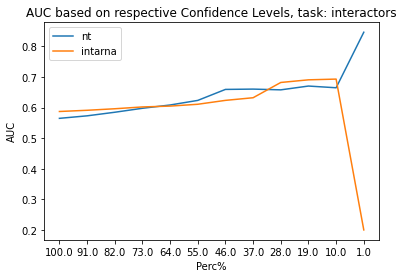

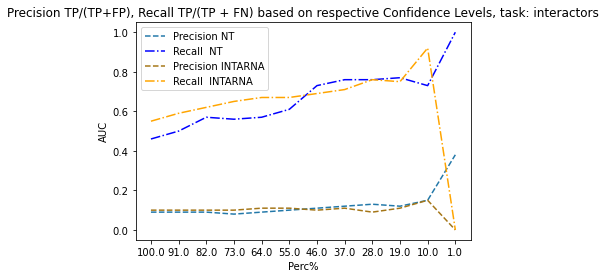



area interval: [21756648, 29628391]
percentile:  64.0
# data:  1340
perc_pos_predicted:  42.0
smartneg    1234
easypos      106
Name: policy, dtype: int64


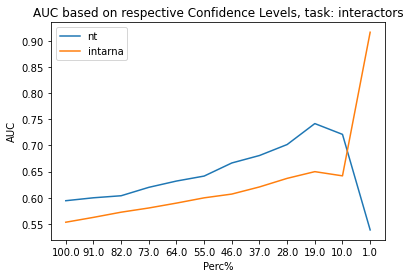

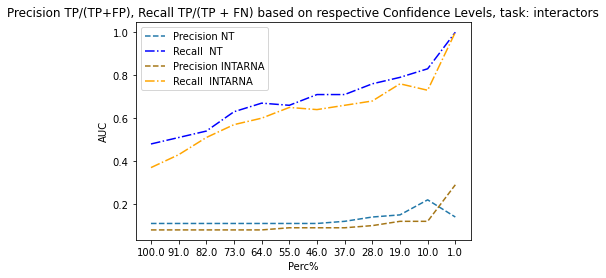



area interval: [29628391, 42512365]
percentile:  73.0
# data:  1517
perc_pos_predicted:  42.0
smartneg    1377
easypos      140
Name: policy, dtype: int64


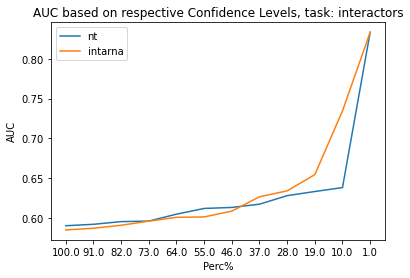

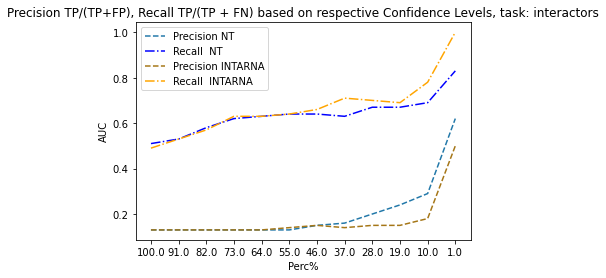



area interval: [42512365, 67377792]
percentile:  82.0
# data:  1615
perc_pos_predicted:  44.0
smartneg    1454
easypos      161
Name: policy, dtype: int64


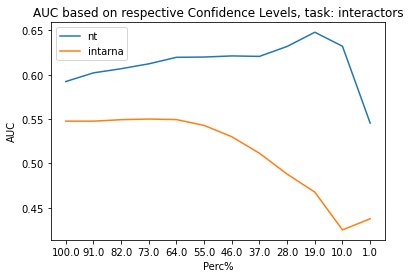

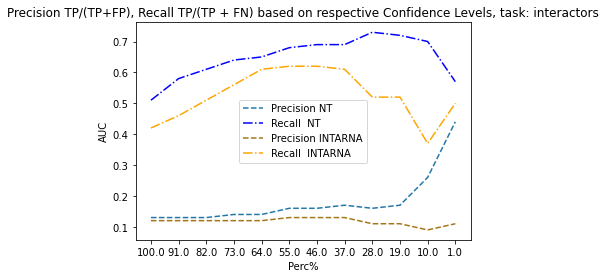



area interval: [67377792, 181968562]
percentile:  91.0
# data:  1626
perc_pos_predicted:  48.0
smartneg    1445
easypos      181
Name: policy, dtype: int64


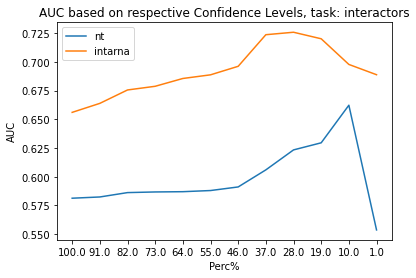

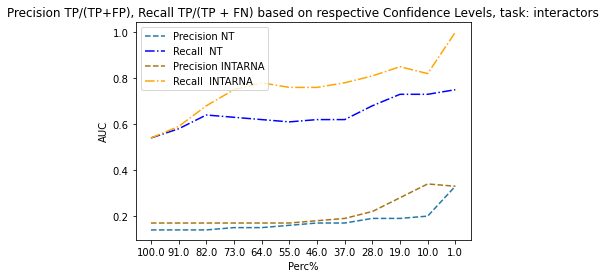



area interval: [181968562, 996507288]
percentile:  100.0
# data:  255
perc_pos_predicted:  52.0
smartneg    214
easypos      41
Name: policy, dtype: int64


/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


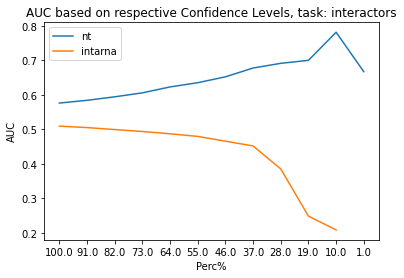

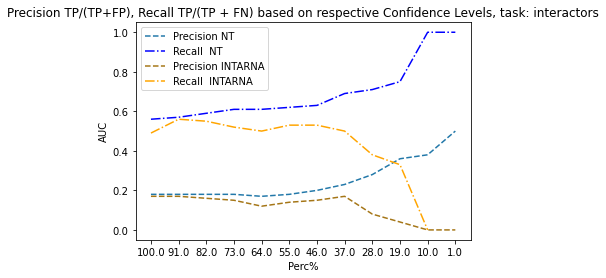

In [21]:
#create quantiles of interaction
df_int = df[(df.interacting)].reset_index(drop = True)
if how == 'ricseq':
    df_int = df[(df.n_reads>=MIN_N_READS_RICSEQ)].reset_index(drop = True)
    
area_values = np.array(df_int.length_1 * df_int.length_2)


N_percentiles = 10

perc_values = np.linspace(10, 100, N_percentiles + 1)


res['original_area'] = res.original_length1 * res.original_length2




n_values = 12
MIN_PERC = 1
space = 'linear' 
plot_ens = False

task = 'interactors'

if task == 'patches':
    policies = ['hardneg', 'easyneg', 'easypos']
elif task == 'interactors':
    policies = ['easypos', 'smartneg']
else:
    raise NotImplementedError
    
    
    
area_value2 = 0
for perc_value in perc_values:
    
    area_value = np.quantile(area_values, perc_value/100)

    area_value1 = area_value2
    area_value2 = area_value
    subset = res[(res.original_area >= area_value1) & (res.original_area <= area_value2)].reset_index(drop = True)
    subset = subset[subset.policy.isin(policies)].reset_index(drop = True)
    
    balanced_subset = balance_df(subset)
    perc_pos = np.round((balanced_subset.probability>0.5).sum()/balanced_subset.shape[0], 2) * 100
    
    #subset = balance_df(subset)
    print(f'area interval: [{int(area_value1)}, {int(area_value2)}]')
    print('percentile: ', perc_value)
    print('# data: ', subset.shape[0])
    print('perc_pos_predicted: ', perc_pos)
    print(subset.policy.value_counts())

    if set(subset.policy.value_counts().index) == set(policies):
        
        confidence_level, auc_nt, _, _ = collect_results_based_on_confidence_level(subset, how = 'nt', MIN_PERC = MIN_PERC, balance = False, n_values = n_values, space = space)
        _, _, auc_intarna, _ = collect_results_based_on_confidence_level(subset, how = 'intarna', MIN_PERC = MIN_PERC, balance = False, n_values = n_values, space = space)
        _, _, _, auc_ens = collect_results_based_on_confidence_level(subset, how = 'ensemble', MIN_PERC = MIN_PERC, balance = False, n_values = n_values, space = space)
        
        # PLOT 1 COMPARE AUC
        plt.plot(confidence_level, auc_nt, label = 'nt')
        plt.plot(confidence_level, auc_intarna, label = 'intarna')
        
        if plot_ens:
            plt.plot(confidence_level, auc_ens, label = 'ensemble')
        plt.title(f'AUC based on respective Confidence Levels, task: {task}')
        plt.legend()

        plt.ylabel('AUC')
        plt.xlabel(f"Perc%")

        plt.show()
        
        
        confidence_level, (prec_nt, recall_nt, spec_nt, npv_nt), (_, _, _, _), (_, _, _, _) = collect_prec_recall_sens_npv_based_on_confidence_level_based_on_percentile(subset, how = 'nt', MIN_PERC = MIN_PERC, balance = False, n_values = n_values)
        _, (_, _, _, _), (prec_intarna, recall_intarna, spec_intarna, npv_intarna), (_, _, _, _) = collect_prec_recall_sens_npv_based_on_confidence_level_based_on_percentile(subset, how = 'intarna', MIN_PERC = MIN_PERC, balance = False, n_values = n_values)
        _, (_, _, _, _), (_, _, _, _), (prec_ens, recall_ens, spec_ens, npv_ens) = collect_prec_recall_sens_npv_based_on_confidence_level_based_on_percentile(subset, how = 'ensemble', MIN_PERC = MIN_PERC, balance = False, n_values = n_values)

        
        # PLOT 2 COMPARE PREC, RECALL
        
        plt.plot(confidence_level, prec_nt, label = 'Precision NT', linestyle = '--', color = '#2278A9')
        plt.plot(confidence_level, recall_nt, label = 'Recall  NT', linestyle = '-.', color = 'blue')
        
        plt.plot(confidence_level, prec_intarna, label = 'Precision INTARNA', linestyle = '--', color = '#A57617')
        plt.plot(confidence_level, recall_intarna, label = 'Recall  INTARNA', linestyle = '-.', color = 'orange')
    
        if plot_ens:
            plt.plot(confidence_level, prec_ens, label = 'Precision ENSEMBLE', linestyle = '--', color = '#22A934')
            plt.plot(confidence_level, recall_ens, label = 'Recall  ENSEMBLE', linestyle = '-.', color = 'green')
            
        plt.title(f'Precision TP/(TP+FP), Recall TP/(TP + FN) based on respective Confidence Levels, task: {task}')
        plt.legend()

        plt.ylabel('AUC')
        plt.xlabel(f"Perc%")

        plt.show()
        
        print('\n')

### Based on treshold

/tmp/ipykernel_614630/3573205076.py:45: RuntimeWarning: invalid value encountered in long_scalars
  perc_pos = np.round((balanced_subset.probability>0.5).sum()/balanced_subset.shape[0], 2) * 100


area interval: [0, 1303316]
percentile:  10.0
# data:  91
perc_pos_predicted:  nan
easypos    91
Name: policy, dtype: int64
area interval: [1303316, 4029408]
percentile:  19.0
# data:  122
perc_pos_predicted:  44.0
easypos    73
easyneg    33
hardneg    16
Name: policy, dtype: int64


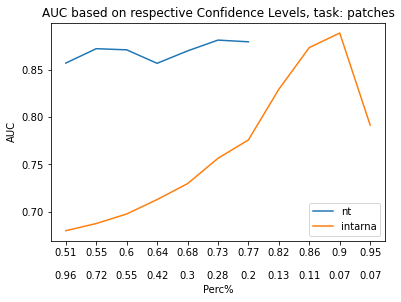

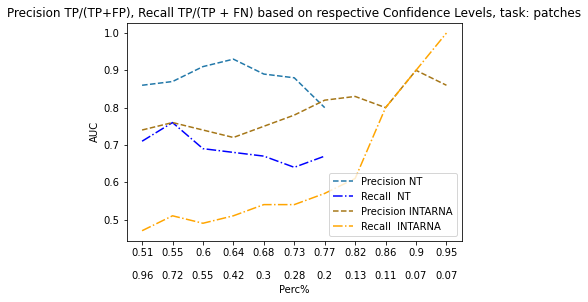



area interval: [4029408, 6975886]
percentile:  28.0
# data:  192
perc_pos_predicted:  34.0
easypos    80
easyneg    66
hardneg    46
Name: policy, dtype: int64


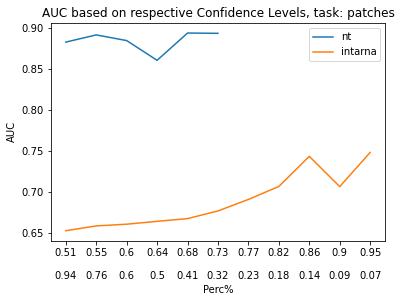

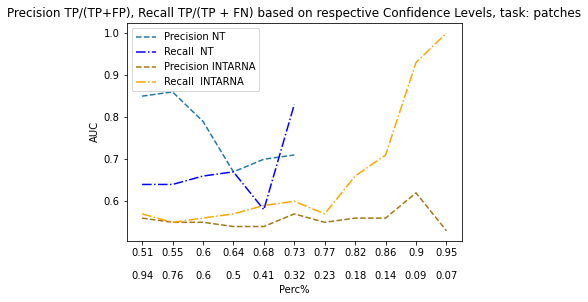



area interval: [6975886, 11303460]
percentile:  37.0
# data:  294
perc_pos_predicted:  35.0
hardneg    104
easyneg     99
easypos     91
Name: policy, dtype: int64


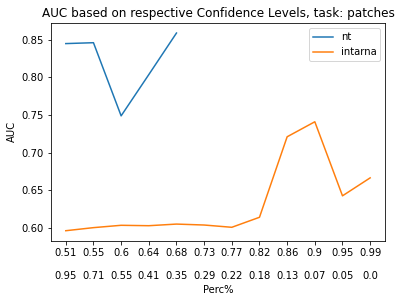

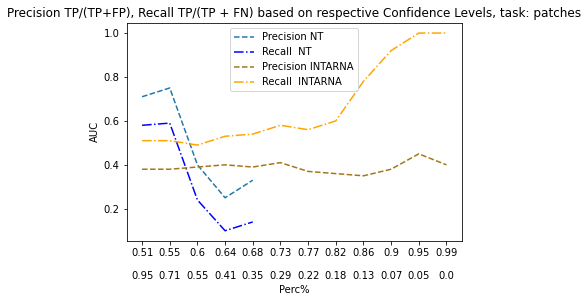



area interval: [11303460, 14905805]
percentile:  46.0
# data:  308
perc_pos_predicted:  36.0
hardneg    116
easypos    103
easyneg     89
Name: policy, dtype: int64


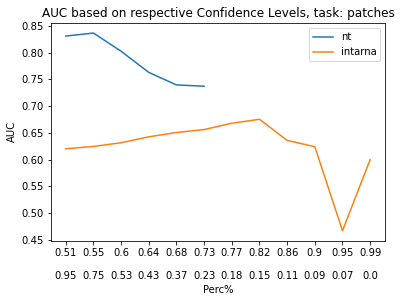

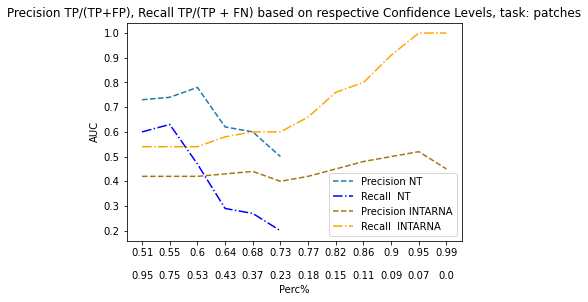



area interval: [14905805, 21756648]
percentile:  55.0
# data:  577
perc_pos_predicted:  28.999999999999996
hardneg    247
easyneg    218
easypos    112
Name: policy, dtype: int64


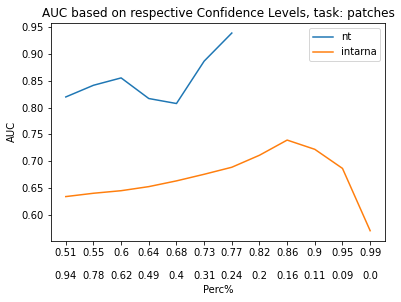

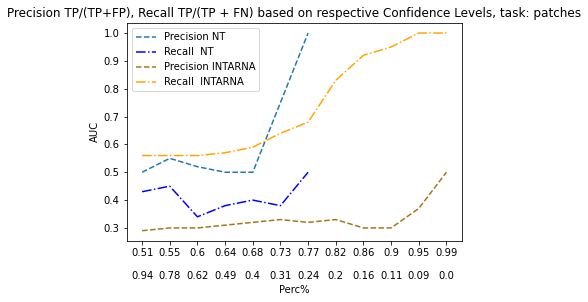



area interval: [21756648, 29628391]
percentile:  64.0
# data:  734
perc_pos_predicted:  28.999999999999996
hardneg    331
easyneg    297
easypos    106
Name: policy, dtype: int64


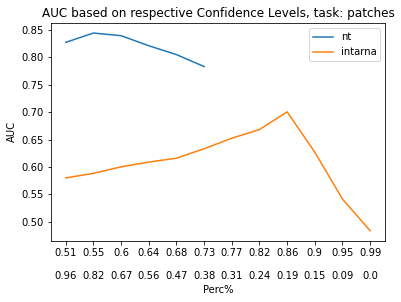

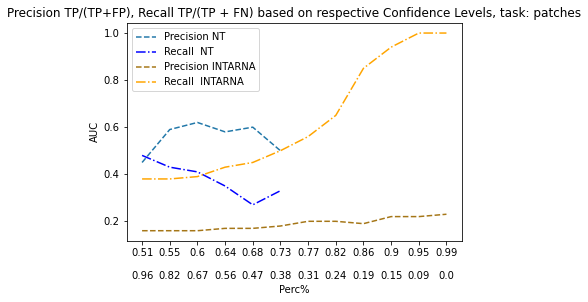



area interval: [29628391, 42512365]
percentile:  73.0
# data:  1168
perc_pos_predicted:  32.0
hardneg    604
easyneg    424
easypos    140
Name: policy, dtype: int64


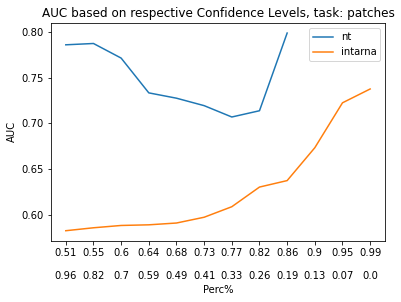

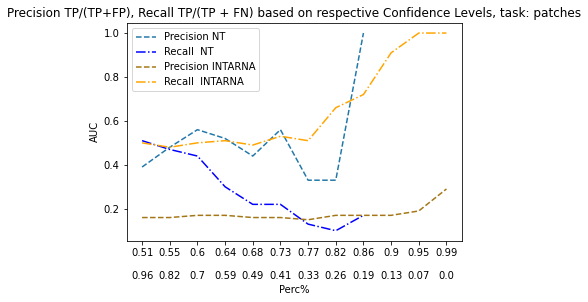



area interval: [42512365, 67377792]
percentile:  82.0
# data:  1745
perc_pos_predicted:  28.999999999999996
hardneg    937
easyneg    647
easypos    161
Name: policy, dtype: int64


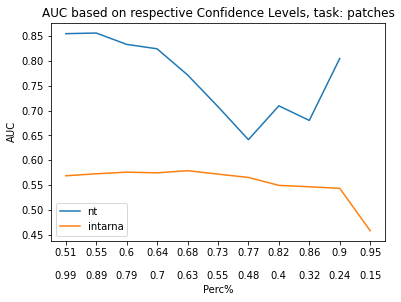

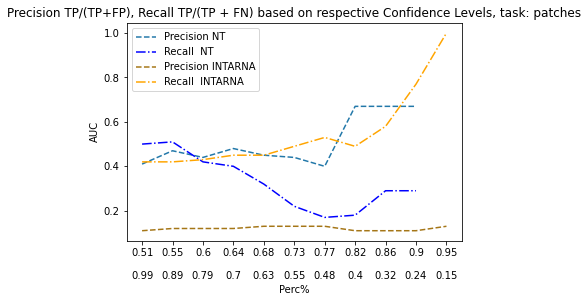



area interval: [67377792, 181968562]
percentile:  91.0
# data:  1940
perc_pos_predicted:  28.000000000000004
hardneg    1105
easyneg     654
easypos     181
Name: policy, dtype: int64


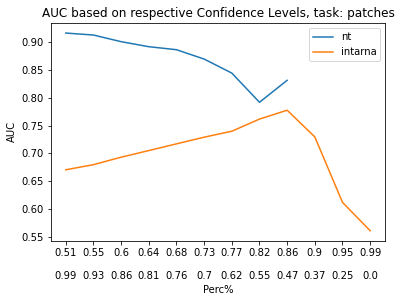

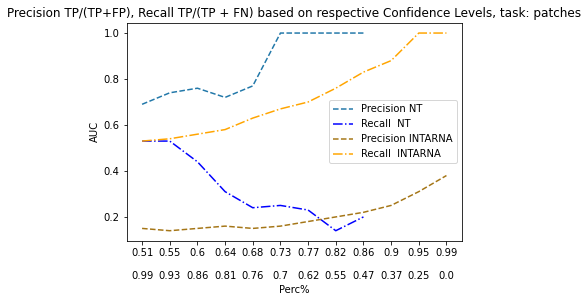



area interval: [181968562, 996507288]
percentile:  100.0
# data:  317
perc_pos_predicted:  28.999999999999996
hardneg    195
easyneg     81
easypos     41
Name: policy, dtype: int64


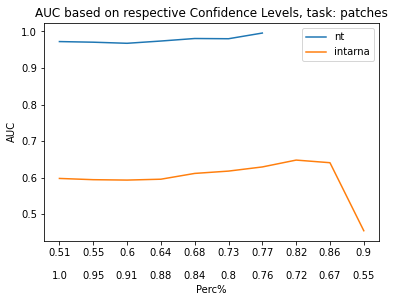

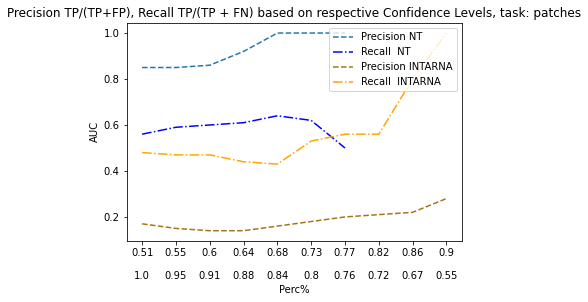

In [24]:
#create quantiles of interaction
df_int = df[(df.interacting)].reset_index(drop = True)
if how == 'ricseq':
    df_int = df[(df.n_reads>=MIN_N_READS_RICSEQ)].reset_index(drop = True)
    
area_values = np.array(df_int.length_1 * df_int.length_2)


N_percentiles = 10

perc_values = np.linspace(10, 100, N_percentiles + 1)


res['original_area'] = res.original_length1 * res.original_length2


n_values = 12
MIN_PERC = 1
MIN_SAMPLES = 4

plot_ens = False

task = 'patches'

if task == 'patches':
    policies = ['hardneg', 'easyneg', 'easypos']
elif task == 'interactors':
    policies = ['easypos', 'smartneg']
else:
    raise NotImplementedError
    
    
    
area_value2 = 0
for perc_value in perc_values:
    
    area_value = np.quantile(area_values, perc_value/100)

    area_value1 = area_value2
    area_value2 = area_value
    subset = res[(res.original_area >= area_value1) & (res.original_area <= area_value2)].reset_index(drop = True)
    subset = subset[subset.policy.isin(policies)].reset_index(drop = True)
    
    balanced_subset = balance_df(subset)
    perc_pos = np.round((balanced_subset.probability>0.5).sum()/balanced_subset.shape[0], 2) * 100
    
    #subset = balance_df(subset)
    print(f'area interval: [{int(area_value1)}, {int(area_value2)}]')
    print('percentile: ', perc_value)
    print('# data: ', subset.shape[0])
    print('perc_pos_predicted: ', perc_pos)
    print(subset.policy.value_counts())

    if set(subset.policy.value_counts().index) == set(policies):
        
        confidence_level, auc_nt, _, _ = collect_results_based_on_confidence_level_based_on_treshold(subset, how = 'nt', MIN_PERC = MIN_PERC, MIN_SAMPLES=MIN_SAMPLES, balance = False, n_values = n_values)
        _, _, auc_intarna, _ = collect_results_based_on_confidence_level_based_on_treshold(subset, how = 'intarna', MIN_PERC = MIN_PERC, MIN_SAMPLES=MIN_SAMPLES, balance = False, n_values = n_values)
        _, _, _, auc_ens = collect_results_based_on_confidence_level_based_on_treshold(subset, how = 'ensemble', MIN_PERC = MIN_PERC, MIN_SAMPLES=MIN_SAMPLES, balance = False, n_values = n_values)
        
        # PLOT 1 COMPARE AUC
        plt.plot(confidence_level, auc_nt, label = 'nt')
        plt.plot(confidence_level, auc_intarna, label = 'intarna')
        
        if plot_ens:
            plt.plot(confidence_level, auc_ens, label = 'ensemble')
        plt.title(f'AUC based on respective Confidence Levels, task: {task}')
        plt.legend()

        plt.ylabel('AUC')
        plt.xlabel(f"Perc%")

        plt.show()
        
        
        confidence_level, (prec_nt, recall_nt, spec_nt, npv_nt), (_, _, _, _), (_, _, _, _) = collect_prec_recall_sens_npv_based_on_confidence_level_based_on_treshold(subset, how = 'nt', MIN_PERC = MIN_PERC, MIN_SAMPLES=MIN_SAMPLES, balance = False, n_values = n_values)
        _, (_, _, _, _), (prec_intarna, recall_intarna, spec_intarna, npv_intarna), (_, _, _, _) = collect_prec_recall_sens_npv_based_on_confidence_level_based_on_treshold(subset, how = 'intarna', MIN_PERC = MIN_PERC, MIN_SAMPLES=MIN_SAMPLES, balance = False, n_values = n_values)
        _, (_, _, _, _), (_, _, _, _), (prec_ens, recall_ens, spec_ens, npv_ens) = collect_prec_recall_sens_npv_based_on_confidence_level_based_on_treshold(subset, how = 'ensemble', MIN_PERC = MIN_PERC, MIN_SAMPLES=MIN_SAMPLES, balance = False, n_values = n_values)

        
        # PLOT 2 COMPARE PREC, RECALL
        
        plt.plot(confidence_level, prec_nt, label = 'Precision NT', linestyle = '--', color = '#2278A9')
        plt.plot(confidence_level, recall_nt, label = 'Recall  NT', linestyle = '-.', color = 'blue')
        
        plt.plot(confidence_level, prec_intarna, label = 'Precision INTARNA', linestyle = '--', color = '#A57617')
        plt.plot(confidence_level, recall_intarna, label = 'Recall  INTARNA', linestyle = '-.', color = 'orange')
    
        if plot_ens:
            plt.plot(confidence_level, prec_ens, label = 'Precision ENSEMBLE', linestyle = '--', color = '#22A934')
            plt.plot(confidence_level, recall_ens, label = 'Recall  ENSEMBLE', linestyle = '-.', color = 'green')
            
        plt.title(f'Precision TP/(TP+FP), Recall TP/(TP + FN) based on respective Confidence Levels, task: {task}')
        plt.legend()

        plt.ylabel('AUC')
        plt.xlabel(f"Perc%")

        plt.show()
        
        print('\n')

# PLOTS

## Metrics

In [26]:
print(res.prediction.value_counts())
print('\n')
print(res.ground_truth.value_counts())

0    12626
1     5610
Name: prediction, dtype: int64


0    17058
1     1178
Name: ground_truth, dtype: int64


In [27]:
n_conf = 10

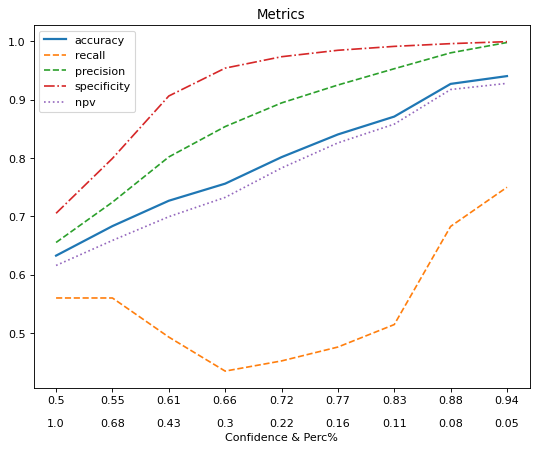

In [28]:
obtain_plot(balance_df(res), n_original_df = res.shape[0], title = 'Metrics', n_conf = n_conf)

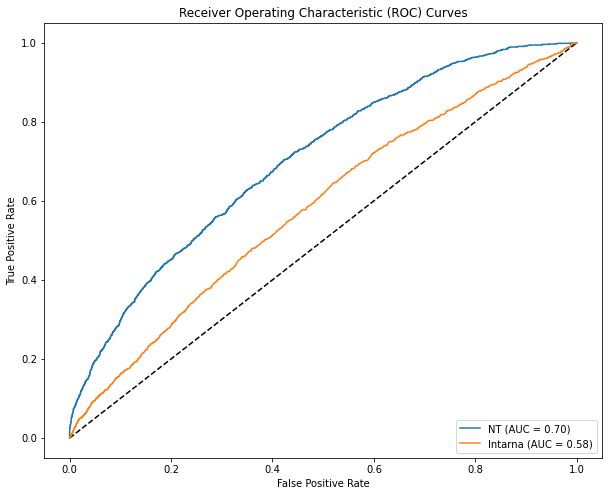

In [29]:
plot_roc_curves([{'prob': res.probability, 'model_name': 'NT'},
                 {'prob': abs(res.E_norm), 'model_name': 'Intarna'}
                ], res.ground_truth)

In [30]:
# no_pc = res[(res['gene1_pc'] == False)|(res['gene2_pc'] == False)]

# obtain_plot(balance_df(no_pc), n_original_df = res.shape[0], title = f'Metrics: At least one is no protein coding', n_conf = n_conf)

0.5735653650254668


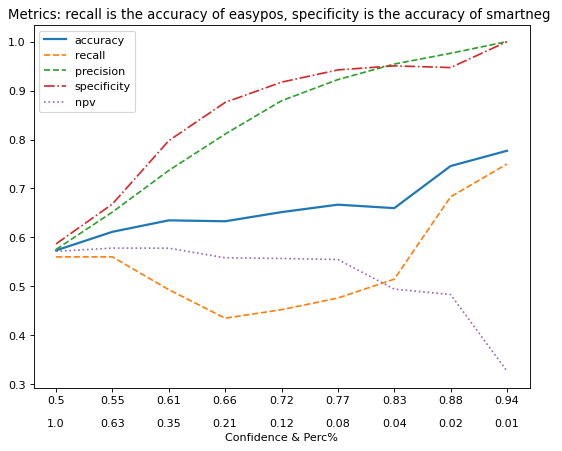

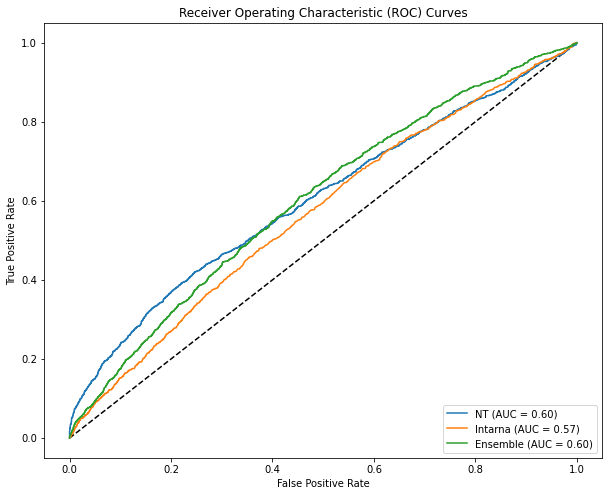

In [31]:
easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])]
balanced_epsn = balance_df(easypos_smartneg)

print(balanced_epsn[balanced_epsn.ground_truth == balanced_epsn.prediction].shape[0]/balanced_epsn.shape[0])

obtain_plot(balanced_epsn, n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of easypos, specificity is the accuracy of smartneg ', n_conf = n_conf)
plot_roc_curves([{'prob': easypos_smartneg.probability, 'model_name': 'NT'},
                 {'prob': abs(easypos_smartneg.E_norm), 'model_name': 'Intarna'},
                 {'prob': abs(easypos_smartneg.ensemble_score), 'model_name': 'Ensemble'},
                ], easypos_smartneg.ground_truth)

0.5665853658536585


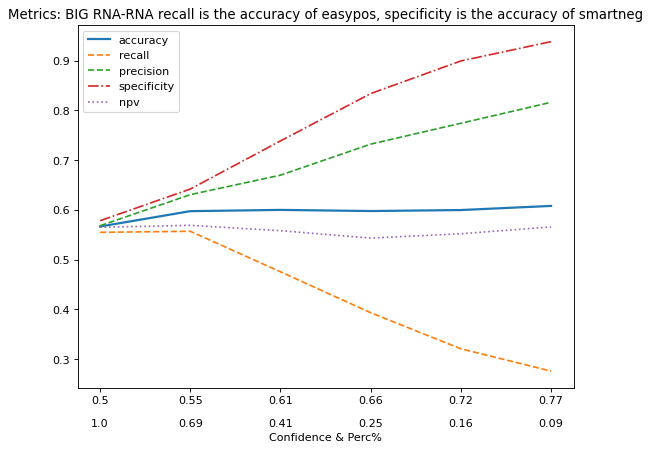

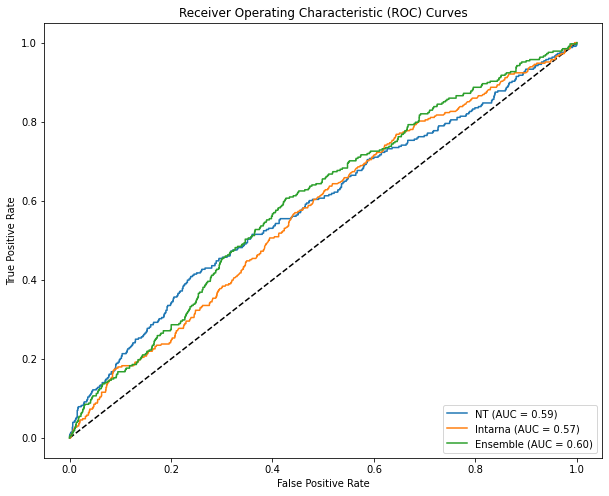

In [32]:
min_len_matrix = 5_000

big_epsn = easypos_smartneg[(easypos_smartneg.original_length1>min_len_matrix) & (easypos_smartneg.original_length2>min_len_matrix)]
big_epsn = balance_df(big_epsn)

print(big_epsn[big_epsn.ground_truth == big_epsn.prediction].shape[0]/big_epsn.shape[0])

obtain_plot(big_epsn, n_original_df = res.shape[0], title = f'Metrics: BIG RNA-RNA recall is the accuracy of easypos, specificity is the accuracy of smartneg', 
            n_conf = n_conf, excluding_treshold = 0.05)

plot_roc_curves([{'prob': big_epsn.probability, 'model_name': 'NT'},
                 {'prob': abs(big_epsn.E_norm), 'model_name': 'Intarna'},
                 {'prob': abs(big_epsn.ensemble_score), 'model_name': 'Ensemble'},
                ], big_epsn.ground_truth)

0.5677439024390244


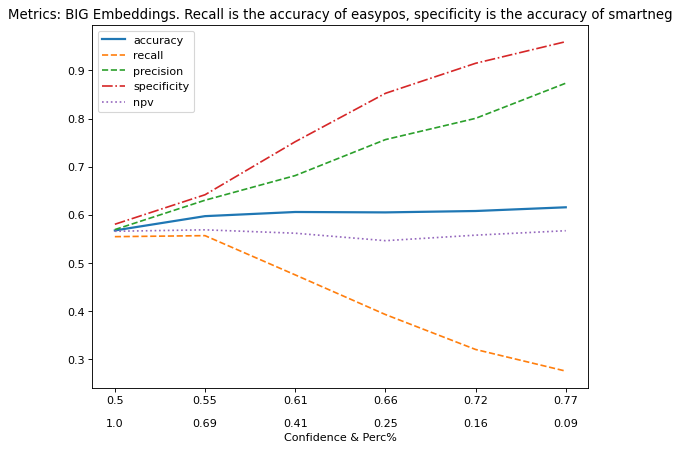

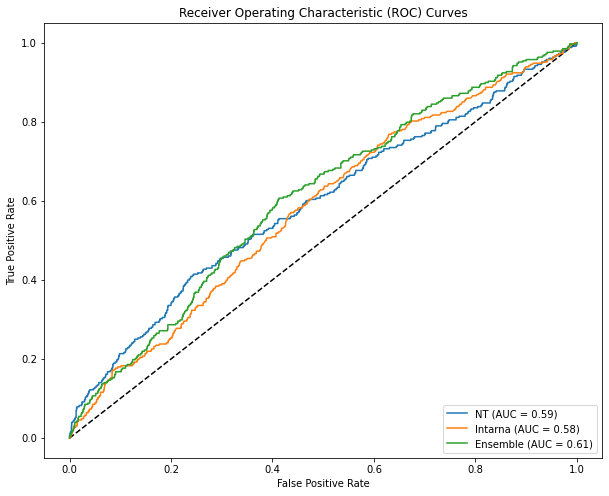

In [33]:
min_len_matrix = 5_000

big_epsn = easypos_smartneg[(easypos_smartneg.len_emb1>min_len_matrix) & (easypos_smartneg.len_emb2>min_len_matrix)]
big_epsn = balance_df(big_epsn)

print(big_epsn[big_epsn.ground_truth == big_epsn.prediction].shape[0]/big_epsn.shape[0])

obtain_plot(big_epsn, n_original_df = res.shape[0], title = f'Metrics: BIG Embeddings. Recall is the accuracy of easypos, specificity is the accuracy of smartneg', 
            n_conf = n_conf, excluding_treshold = 0.05)

plot_roc_curves([{'prob': big_epsn.probability, 'model_name': 'NT'},
                 {'prob': abs(big_epsn.E_norm), 'model_name': 'Intarna'},
                 {'prob': abs(big_epsn.ensemble_score), 'model_name': 'Ensemble'},
                ], big_epsn.ground_truth)

0.5614024390243902


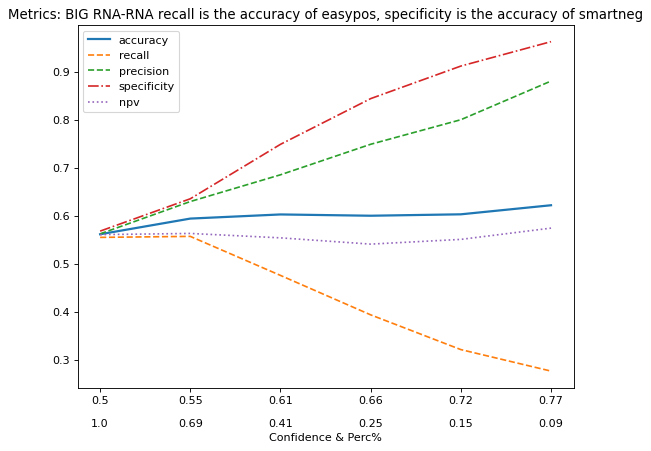

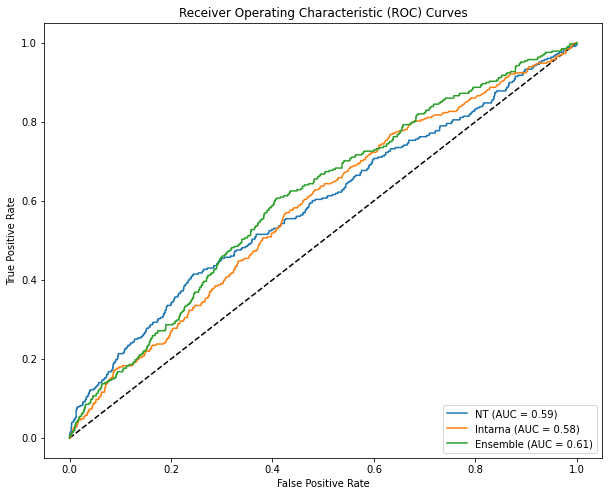

In [34]:
big_epsn = easypos_smartneg[(easypos_smartneg.original_length1>min_len_matrix) & (easypos_smartneg.original_length2>min_len_matrix)]
big_epsn = balance_df(big_epsn)

print(big_epsn[big_epsn.ground_truth == big_epsn.prediction].shape[0]/big_epsn.shape[0])

obtain_plot(big_epsn, n_original_df = res.shape[0], title = f'Metrics: BIG RNA-RNA recall is the accuracy of easypos, specificity is the accuracy of smartneg', 
            n_conf = n_conf, excluding_treshold = 0.05)

plot_roc_curves([{'prob': big_epsn.probability, 'model_name': 'NT'},
                 {'prob': abs(big_epsn.E_norm), 'model_name': 'Intarna'},
                 {'prob': abs(big_epsn.ensemble_score), 'model_name': 'Ensemble'},
                ], big_epsn.ground_truth)

0.536923076923077


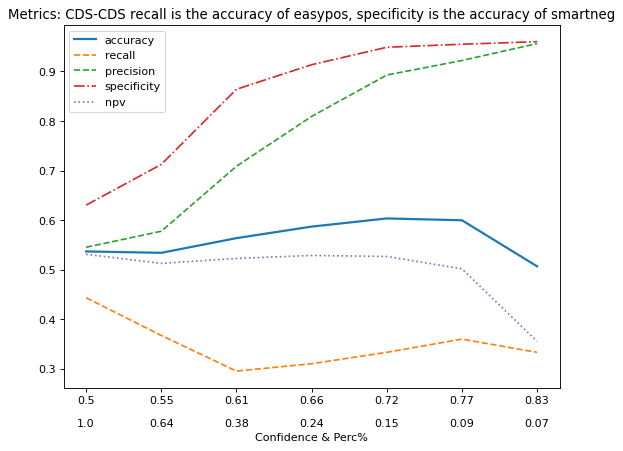

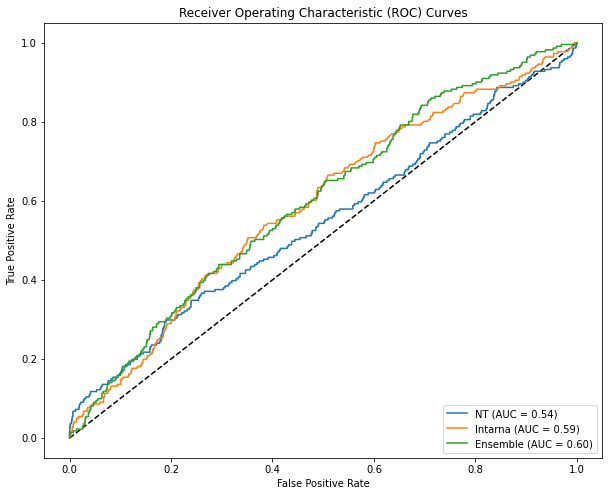

In [35]:
easypos_smartneg_balanced = balance_df(easypos_smartneg[easypos_smartneg.id_sample.isin(id_cds_cds)])

print((easypos_smartneg_balanced.prediction == easypos_smartneg_balanced.ground_truth).sum()/easypos_smartneg_balanced.shape[0])


obtain_plot(easypos_smartneg_balanced, n_original_df = res.shape[0], title = f'Metrics: CDS-CDS recall is the accuracy of easypos, specificity is the accuracy of smartneg', 
            n_conf = n_conf, excluding_treshold = 0.05)

plot_roc_curves([{'prob': easypos_smartneg_balanced.probability, 'model_name': 'NT'},
                 {'prob': abs(easypos_smartneg_balanced.E_norm), 'model_name': 'Intarna'},
                 {'prob': abs(easypos_smartneg_balanced.ensemble_score), 'model_name': 'Ensemble'},
                ], easypos_smartneg_balanced.ground_truth)

0.5756530825496343


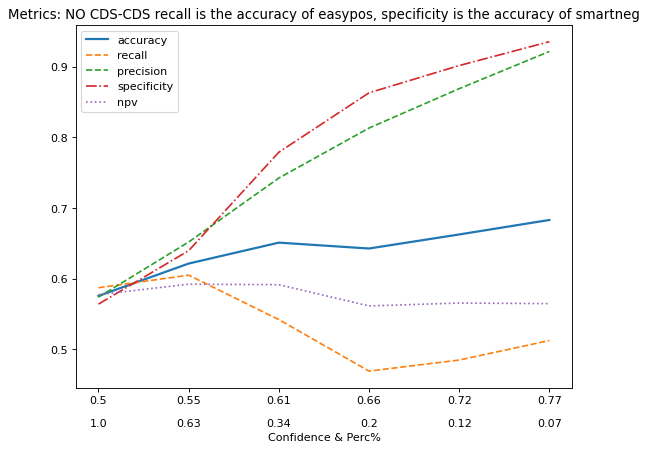

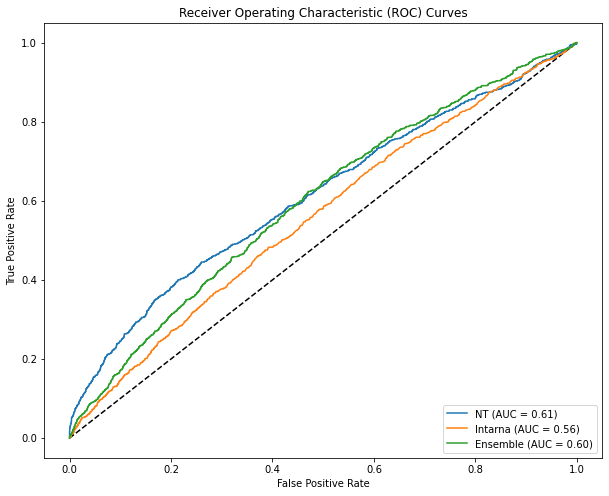

In [36]:
easypos_smartneg_balanced = balance_df(easypos_smartneg[~easypos_smartneg.id_sample.isin(id_cds_cds)])

print((easypos_smartneg_balanced.prediction == easypos_smartneg_balanced.ground_truth).sum()/easypos_smartneg_balanced.shape[0])


obtain_plot(easypos_smartneg_balanced, n_original_df = res.shape[0], title = f'Metrics: NO CDS-CDS recall is the accuracy of easypos, specificity is the accuracy of smartneg', 
            n_conf = n_conf, excluding_treshold = 0.05)

plot_roc_curves([{'prob': easypos_smartneg_balanced.probability, 'model_name': 'NT'},
                 {'prob': abs(easypos_smartneg_balanced.E_norm), 'model_name': 'Intarna'},
                 {'prob': abs(easypos_smartneg_balanced.ensemble_score), 'model_name': 'Ensemble'},
                ], easypos_smartneg_balanced.ground_truth)

0.5952095808383233


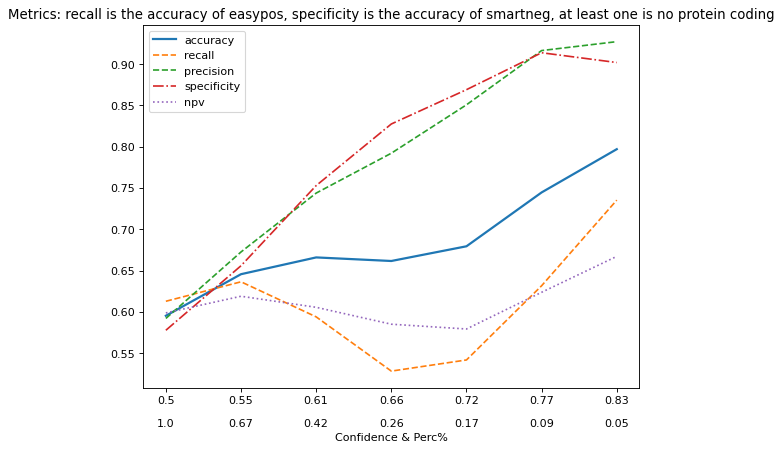

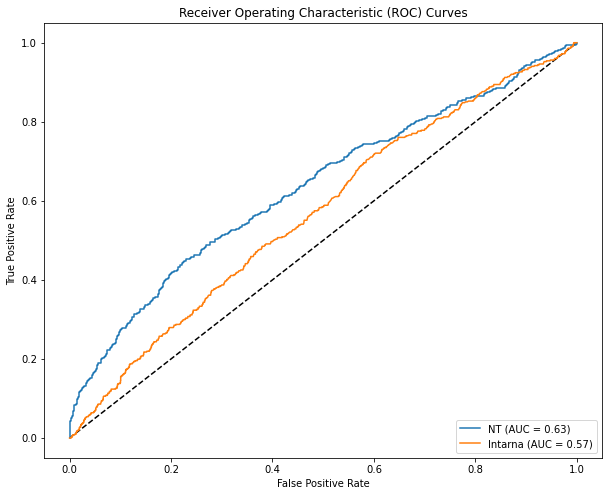

In [37]:
nopc = easypos_smartneg[(easypos_smartneg.gene1_pc == False)|(easypos_smartneg.gene2_pc == False)]
if how =='splash':
    print(nopc.shape[0])
    if nopc.shape[0]>0:
        print(nopc[nopc.ground_truth == nopc.prediction].shape[0]/nopc.shape[0])

else:
    balanced_epsn_nopc = balance_df(nopc)
    print(balanced_epsn_nopc[balanced_epsn_nopc.ground_truth == balanced_epsn_nopc.prediction].shape[0]/balanced_epsn_nopc.shape[0])


    obtain_plot(balanced_epsn_nopc, n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of easypos, specificity is the accuracy of smartneg, at least one is no protein coding', 
                n_conf = n_conf, excluding_treshold = 0.05)

    plot_roc_curves([{'prob': nopc.probability, 'model_name': 'NT'},
                     {'prob': abs(nopc.E_norm), 'model_name': 'Intarna'}
                    ], nopc.ground_truth)

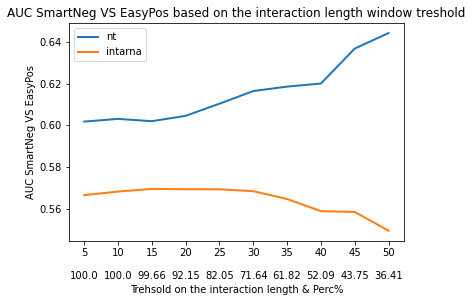

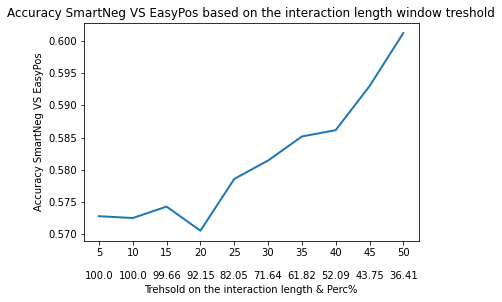

In [38]:
MIN_PERC = 1

def obtain_auc_and_perc(treshold, res, test500, balance = True, intarna = False):
    original_res_shape = res.shape[0]
    #take only big windows
    subset = test500[ (abs(test500.seed_x1 - test500.seed_x2) >treshold) & (abs(test500.seed_y1 - test500.seed_y2) > treshold) ]
    res = res[res.id_sample.isin(subset.couples)]
    
    perc = np.round((res.shape[0] / original_res_shape)*100, 2)
    
    if balance:
        res = balance_df(res)
    
    if intarna:
        fpr, tpr, _ = roc_curve(abs(1 - res.ground_truth), res.E_norm)
        roc_auc = auc(fpr, tpr)
    else:
        fpr, tpr, _ = roc_curve(res.ground_truth, res.probability)
        roc_auc = auc(fpr, tpr)
    
    return roc_auc, perc

def obtain_acc_and_perc(treshold, res, test500, balance = True):
    original_res_shape = res.shape[0]
    #take only big windows
    subset = test500[ (abs(test500.seed_x1 - test500.seed_x2) >treshold) & (abs(test500.seed_y1 - test500.seed_y2) > treshold) ]
    res = res[res.id_sample.isin(subset.couples)]
    
    perc = np.round((res.shape[0] / original_res_shape)*100, 2)
    
    if balance:
        res = balance_df(res)

    acc = (res.prediction == res.ground_truth).sum()/res.shape[0]
    return acc, perc

tresholds = np.linspace(5, 50, 10).astype(int)
accuracies = []
aucs_nt = []
aucs_intarna = []
percs = []
for treshold in tresholds:
    acc, perc = obtain_acc_and_perc(treshold, easypos_smartneg, test500)
    if perc > MIN_PERC:
        accuracies.append(acc)
        roc_auc, perc = obtain_auc_and_perc(treshold, easypos_smartneg, test500, balance = True, intarna = False)
        aucs_nt.append(roc_auc)
        roc_auc, perc = obtain_auc_and_perc(treshold, easypos_smartneg, test500, balance = True, intarna = True)
        aucs_intarna.append(roc_auc)
        percs.append(perc)

merged_x_axis = []
for i in range(0, len(percs)):
    tuple_to_print = (np.round(tresholds[i],2), np.round(percs[i], 2))
    merged_x_axis.append('\n\n'.join(str(x) for x in tuple_to_print))

plt.title('AUC SmartNeg VS EasyPos based on the interaction length window treshold')

plt.plot(merged_x_axis, aucs_nt, label = 'nt', linewidth=2)
plt.plot(merged_x_axis, aucs_intarna, label = 'intarna', linewidth=2)

plt.xlabel(f"Trehsold on the interaction length & Perc%")
plt.ylabel(f"AUC SmartNeg VS EasyPos")
plt.legend()

plt.show()


merged_x_axis = []
for i in range(0, len(percs)):
    tuple_to_print = (np.round(tresholds[i],2), np.round(percs[i], 2))
    merged_x_axis.append('\n\n'.join(str(x) for x in tuple_to_print))

plt.title('Accuracy SmartNeg VS EasyPos based on the interaction length window treshold')

plt.plot(merged_x_axis, accuracies, label = 'accuracy', linewidth=2)

plt.xlabel(f"Trehsold on the interaction length & Perc%")
plt.ylabel(f"Accuracy SmartNeg VS EasyPos")

plt.show()

0.912328028055031


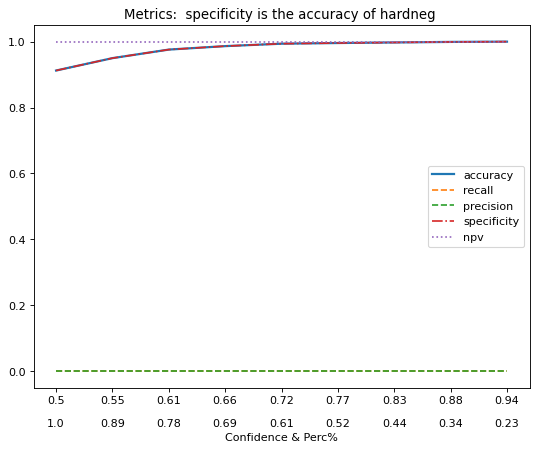

In [39]:
hn = res[(res.policy == 'hardneg')]

if hn.shape[0]>0:
    print(hn[hn.ground_truth == hn.prediction].shape[0]/hn.shape[0])
    obtain_plot(hn, n_original_df = res.shape[0], title = f'Metrics:  specificity is the accuracy of hardneg ', n_conf = n_conf)

0.9402298850574713


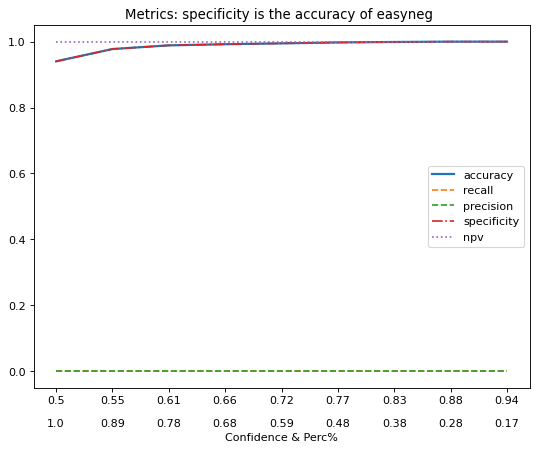

In [40]:
easy = res[(res.policy == 'easyneg')]
print(easy[easy.ground_truth == easy.prediction].shape[0]/easy.shape[0])

obtain_plot(easy, n_original_df = res.shape[0], title = f'Metrics: specificity is the accuracy of easyneg ', n_conf = n_conf)

0.5602716468590832


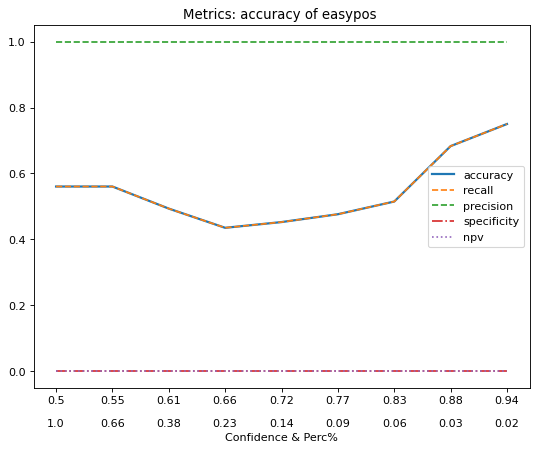

In [41]:
ep = res[(res.policy == 'easypos')]
print(ep[ep.ground_truth == ep.prediction].shape[0]/ep.shape[0])

obtain_plot(ep, n_original_df = res.shape[0], title = f'Metrics: accuracy of easypos ', n_conf = n_conf)

0.5839307327064519


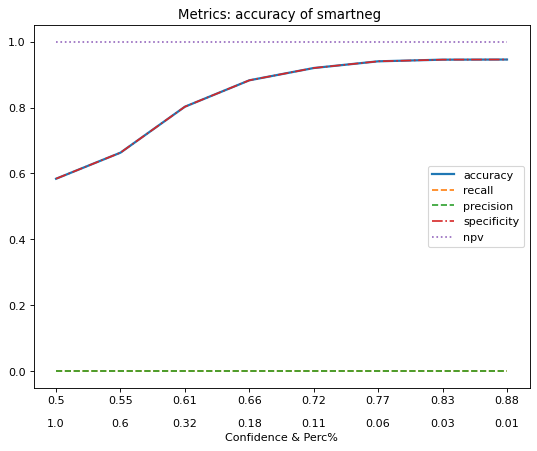

In [42]:
sn = res[(res.policy == 'smartneg')]
print(sn[sn.ground_truth == sn.prediction].shape[0]/sn.shape[0])

obtain_plot(sn, n_original_df = res.shape[0], title = f'Metrics: accuracy of smartneg ', n_conf = n_conf)

0.7430390492359932


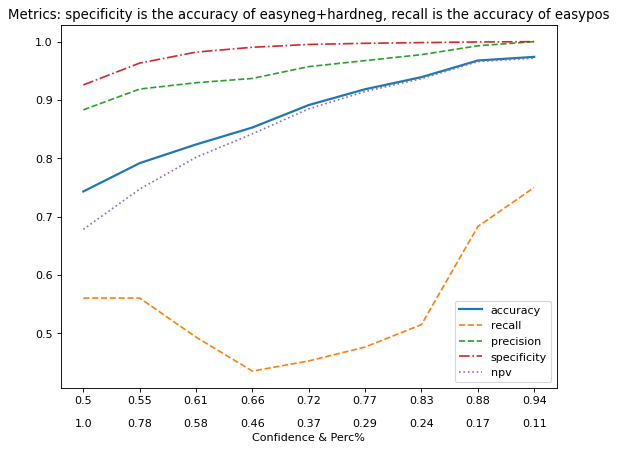

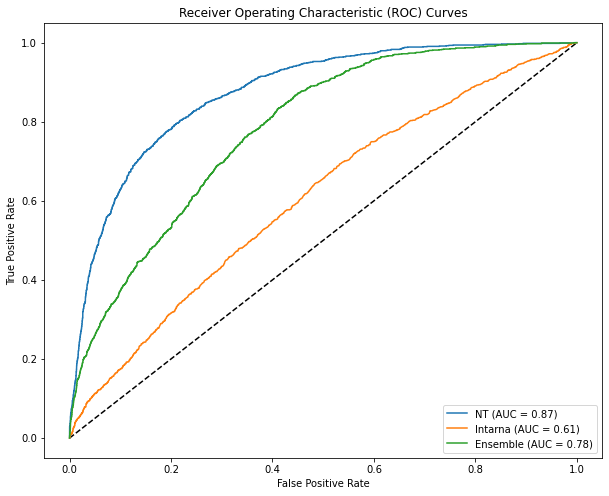

In [43]:
ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')]

ephnen_sampled = balance_df(ephnen)

print(ephnen_sampled[ephnen_sampled.ground_truth == ephnen_sampled.prediction].shape[0]/ephnen_sampled.shape[0])
obtain_plot(ephnen_sampled, n_original_df = res.shape[0], title = f'Metrics: specificity is the accuracy of easyneg+hardneg, recall is the accuracy of easypos', n_conf = n_conf)

plot_roc_curves([{'prob': ephnen_sampled.probability, 'model_name': 'NT'},
                 {'prob': abs(ephnen_sampled.E_norm), 'model_name': 'Intarna'},
                 {'prob': abs(ephnen_sampled.ensemble_score), 'model_name': 'Ensemble'},
                ], ephnen_sampled.ground_truth)

0.756280487804878


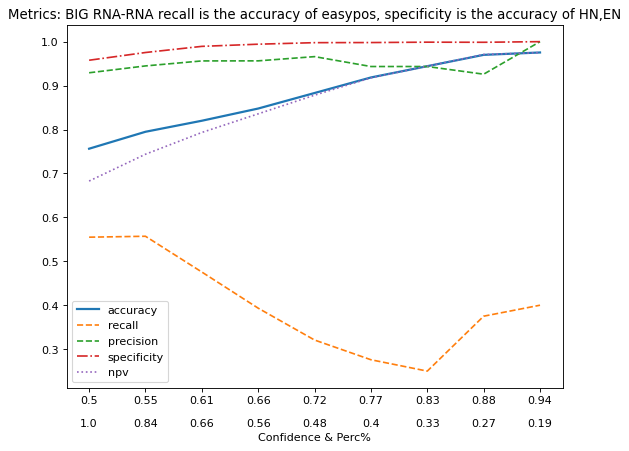

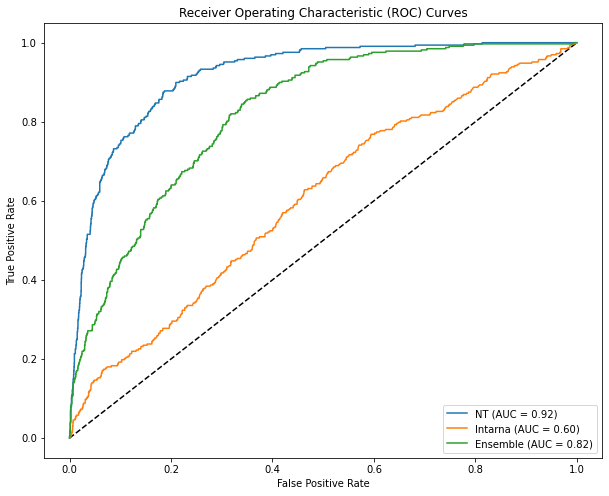

In [44]:
big_ephnen = ephnen[(ephnen.original_length1>min_len_matrix) & (ephnen.original_length2>min_len_matrix)]
big_ephnen = balance_df(big_ephnen)

print(big_ephnen[big_ephnen.ground_truth == big_ephnen.prediction].shape[0]/big_ephnen.shape[0])

obtain_plot(big_ephnen, n_original_df = res.shape[0], title = f'Metrics: BIG RNA-RNA recall is the accuracy of easypos, specificity is the accuracy of HN,EN', 
            n_conf = n_conf, excluding_treshold = 0.05)

plot_roc_curves([{'prob': big_ephnen.probability, 'model_name': 'NT'},
                 {'prob': abs(big_ephnen.E_norm), 'model_name': 'Intarna'},
                 {'prob': abs(big_ephnen.ensemble_score), 'model_name': 'Ensemble'},
                ], big_ephnen.ground_truth)

hardneg    3707
easyneg    2610
easypos    1178
Name: policy, dtype: int64
0.7487855297157623


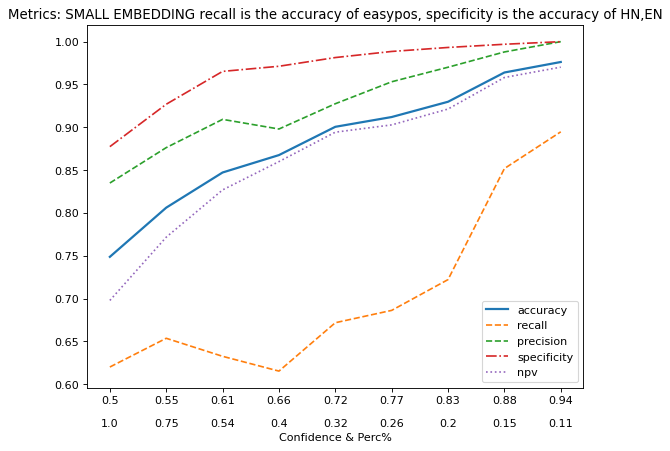

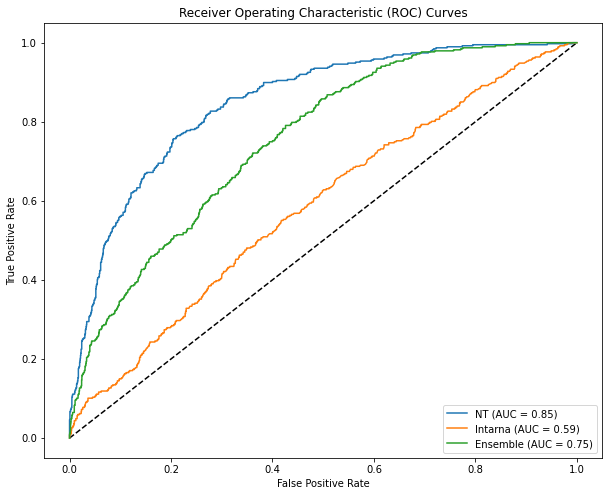

In [45]:
max_len_emb = 3_000
small_ephnen = ephnen[(ephnen.len_emb1<max_len_emb) & (ephnen.len_emb1<max_len_emb)]
print(ephnen.policy.value_counts())
small_ephnen = balance_df(small_ephnen)

print(small_ephnen[small_ephnen.ground_truth == small_ephnen.prediction].shape[0]/small_ephnen.shape[0])

obtain_plot(small_ephnen, n_original_df = res.shape[0], title = f'Metrics: SMALL EMBEDDING recall is the accuracy of easypos, specificity is the accuracy of HN,EN', 
            n_conf = n_conf, excluding_treshold = 0.05)

plot_roc_curves([{'prob': small_ephnen.probability, 'model_name': 'NT'},
                 {'prob': abs(small_ephnen.E_norm), 'model_name': 'Intarna'},
                 {'prob': abs(small_ephnen.ensemble_score), 'model_name': 'Ensemble'},
                ], small_ephnen.ground_truth)

In [46]:
# confidence_level = 0.7
# high_prob_pairs = easypos_smartneg[(easypos_smartneg.probability>confidence_level)|(easypos_smartneg.probability<(1-confidence_level))]

# obtain_plot(balance_df(high_prob_pairs), n_original_df = easypos_smartneg.shape[0], title = f'Metrics: The model is very confident (easypos VS smartneg) ', n_conf = n_conf)
# plot_roc_curves([{'prob': high_prob_pairs.probability, 'model_name': 'NT-predictor'}], high_prob_pairs.ground_truth)

In [47]:
# import dataset.preprocessing as utils
# def order_genes(x):
#     x1, x2 = x.split('_')
#     return utils.get_couple_id(x1, x2)

# prohibited_couples = pd.read_csv(os.path.join(original_files_dir, 'prohibited_couples.txt'), sep = '\t')
# prohibited_couples['messy_id'] = prohibited_couples['gene_id1'] + '_' + prohibited_couples['gene_id2']
# prohibited_couples['id'] = prohibited_couples['messy_id'].apply(order_genes)

# Compare with INTARNA

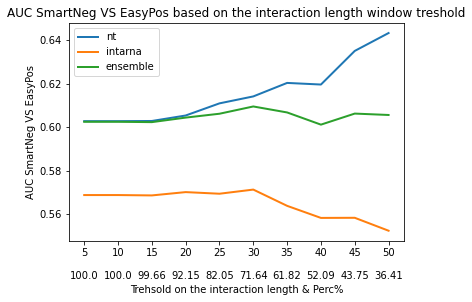

In [48]:
def obtain_auc_and_perc(treshold, res, test500, balance = True, intarna = False, ensemble = False):
    original_res_shape = res.shape[0]
    #take only big windows
    subset = test500[ (abs(test500.seed_x1 - test500.seed_x2) >treshold) & (abs(test500.seed_y1 - test500.seed_y2) > treshold) ]
    res = res[res.id_sample.isin(subset.couples)]
    
    perc = np.round((res.shape[0] / original_res_shape)*100, 2)
    
    if balance:
        res = balance_df(res)
    
    if intarna:
        fpr, tpr, _ = roc_curve(abs(1 - res.ground_truth), res.E_norm)
        roc_auc = auc(fpr, tpr)
    else:
        fpr, tpr, _ = roc_curve(res.ground_truth, res.probability)
        roc_auc = auc(fpr, tpr)
        
    if ensemble:
        fpr, tpr, _ = roc_curve(res.ground_truth, res.ensemble_score)
        roc_auc = auc(fpr, tpr)
    
    return roc_auc, perc

tresholds = np.linspace(5, 50, 10).astype(int)
aucs_nt = []
aucs_intarna = []
aucs_ens = []
percs = []
for treshold in tresholds:
    roc_auc, perc = obtain_auc_and_perc(treshold, easypos_smartneg, test500, balance = False, intarna = False, ensemble = False)
    aucs_nt.append(roc_auc)
    roc_auc, perc = obtain_auc_and_perc(treshold, easypos_smartneg, test500, balance = False, intarna = True, ensemble = False)
    aucs_intarna.append(roc_auc)
    roc_auc, perc = obtain_auc_and_perc(treshold, easypos_smartneg, test500, balance = False, intarna = True, ensemble = True)
    aucs_ens.append(roc_auc)
    percs.append(perc)

merged_x_axis = []
for i in range(0, len(percs)):
    tuple_to_print = (np.round(tresholds[i],2), np.round(percs[i], 2))
    merged_x_axis.append('\n\n'.join(str(x) for x in tuple_to_print))

plt.title('AUC SmartNeg VS EasyPos based on the interaction length window treshold')

plt.plot(merged_x_axis, aucs_nt, label = 'nt', linewidth=2)
plt.plot(merged_x_axis, aucs_intarna, label = 'intarna', linewidth=2)
plt.plot(merged_x_axis, aucs_ens, label = 'ensemble', linewidth=2)

plt.xlabel(f"Trehsold on the interaction length & Perc%")
plt.ylabel(f"AUC SmartNeg VS EasyPos")
plt.legend()

#### Compare AUC based on confidence

In [49]:
import seaborn as sns

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


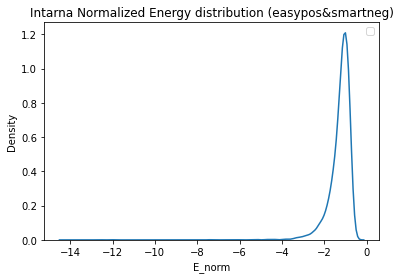

In [50]:
sns.kdeplot(easypos_smartneg.E_norm)
plt.title(f'Intarna Normalized Energy distribution (easypos&smartneg)')
plt.legend()
plt.show()

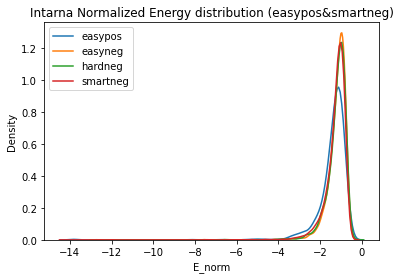

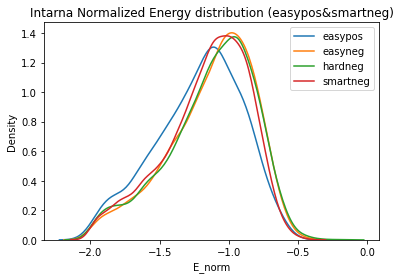

In [51]:
sns.kdeplot(res[res.policy == 'easypos'].E_norm, label = 'easypos')
sns.kdeplot(res[res.policy == 'easyneg'].E_norm, label = 'easyneg')
sns.kdeplot(res[res.policy == 'hardneg'].E_norm, label = 'hardneg')
sns.kdeplot(res[res.policy == 'smartneg'].E_norm, label = 'smartneg')
plt.title(f'Intarna Normalized Energy distribution (easypos&smartneg)')
plt.legend()
plt.show()

treshold_plot = -2
sns.kdeplot(res[(res.policy == 'easypos')&(res.E_norm>treshold_plot)].E_norm, label = 'easypos')
sns.kdeplot(res[(res.policy == 'easyneg')&(res.E_norm>treshold_plot)].E_norm, label = 'easyneg')
sns.kdeplot(res[(res.policy == 'hardneg')&(res.E_norm>treshold_plot)].E_norm, label = 'hardneg')
sns.kdeplot(res[(res.policy == 'smartneg')&(res.E_norm>treshold_plot)].E_norm, label = 'smartneg')
plt.title(f'Intarna Normalized Energy distribution (easypos&smartneg)')
plt.legend()
plt.show()

In [52]:
def plot_ROC_based_on_confidence(df, how = 'intarna', treshold = 0.05, balance = False):
    if how == 'intarna':
        subset = df[
            (df.E_norm <= df.E_norm.quantile(treshold))|
            (df.E_norm >= df.E_norm.quantile(1-treshold))
        ]
    elif how == 'nt':
        subset = df[
            (df.probability <= treshold)|
            (df.probability >= (1-treshold))
        ]
    else:
        raise NotImplementedError
    print('perc of the total data: ', np.round(subset.shape[0]/df.shape[0], 3)*100, '%')
    if balance:
        subset = balance_df(subset)
    plot_roc_curves([{'prob': subset.probability, 'model_name': 'NT'},
                 {'prob': abs(subset.E_norm), 'model_name': 'Intarna'}
                ], subset.ground_truth)

perc of the total data:  10.0 %


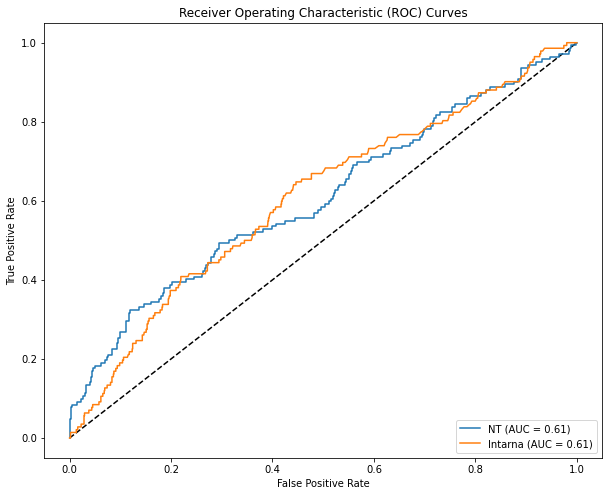

In [53]:
plot_ROC_based_on_confidence(easypos_smartneg, treshold = 0.05)

perc of the total data:  13.3 %


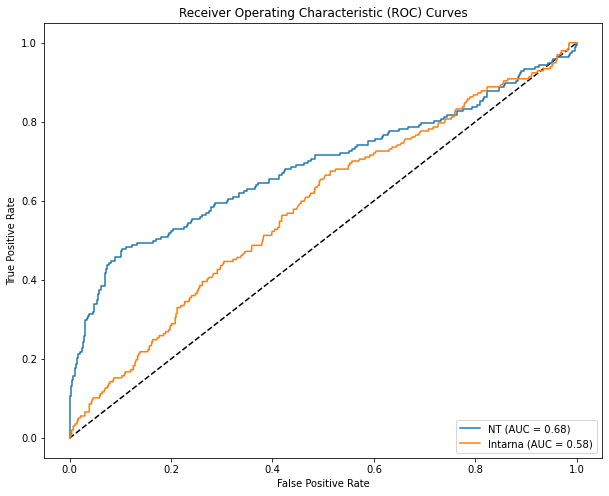

In [54]:
plot_ROC_based_on_confidence(easypos_smartneg, how = 'nt', treshold = 0.3)

Text(0.5, 0, 'Perc%')

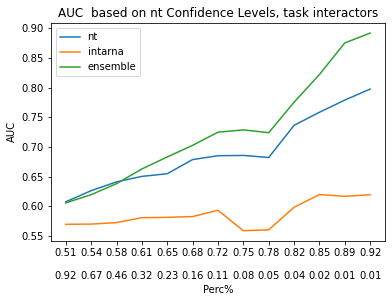

In [82]:
n_values = 15
MIN_PERC = 0.5
rank_by = 'nt'

based_on_treshold = True

if based_on_treshold:
    function = collect_results_based_on_confidence_level_based_on_treshold
else:
    function = collect_results_based_on_confidence_level

confidence_level, auc_nt, auc_intarna, auc_ens = function(easypos_smartneg, how = rank_by, MIN_PERC = MIN_PERC, balance = False, n_values = n_values)
plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.plot(confidence_level, auc_ens, label = 'ensemble')
plt.title(f'AUC  based on {rank_by} Confidence Levels, task interactors')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Perc%")

Text(0.5, 0, 'Perc%')

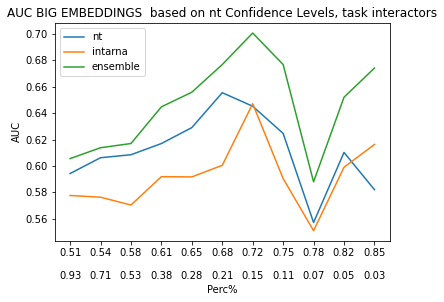

In [83]:
confidence_level, auc_nt, auc_intarna, auc_ens = function(easypos_smartneg[(easypos_smartneg.len_emb1 > 5000) & (easypos_smartneg.len_emb2 > 5000)], how = rank_by, MIN_PERC = MIN_PERC, balance = False, n_values = n_values)
plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.plot(confidence_level, auc_ens, label = 'ensemble')
plt.title(f'AUC BIG EMBEDDINGS  based on {rank_by} Confidence Levels, task interactors')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Perc%")

Text(0.5, 0, 'Perc%')

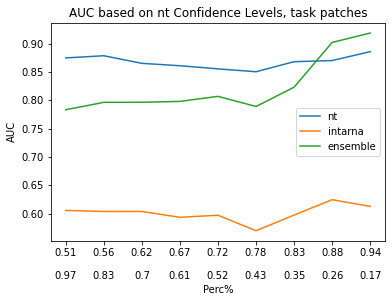

In [84]:
n_values = 10
MIN_PERC = 0.5
rank_by = 'nt'

based_on_treshold = True

if based_on_treshold:
    function = collect_results_based_on_confidence_level_based_on_treshold
else:
    function = collect_results_based_on_confidence_level

confidence_level, auc_nt, auc_intarna, auc_ens = function(ephnen, how = rank_by, MIN_PERC = MIN_PERC, balance = False, n_values = n_values)
plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.plot(confidence_level, auc_ens, label = 'ensemble')
plt.title(f'AUC based on {rank_by} Confidence Levels, task patches')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Perc%")

Text(0.5, 0, 'Perc%')

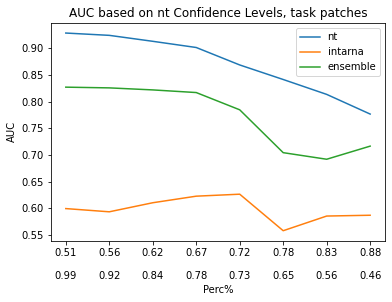

In [85]:
confidence_level, auc_nt, auc_intarna, auc_ens = function(ephnen[(ephnen.len_emb1 > 5000) & (ephnen.len_emb2 > 5000)], how = rank_by, MIN_PERC = MIN_PERC, balance = False, n_values = n_values)
plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.plot(confidence_level, auc_ens, label = 'ensemble')
plt.title(f'AUC based on {rank_by} Confidence Levels, task patches')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Perc%")

# Repeats enrichment

In [99]:
feature_to_search = 'Simple_repeat' #'Simple_repeat' 'Low_complexity' 'SINE'

full_overlap = False

if full_overlap:
    suffix = 'full_'
else:
    suffix = ''

sr1 = test500[test500[f'{suffix}feature1'].apply(lambda x: feature_to_search in x)].couples
sr2 = test500[test500[f'{suffix}feature2'].apply(lambda x: feature_to_search in x)].couples

none1 = test500[test500[f'{suffix}feature1'].apply(lambda x: 'None' in x)].couples
none2 = test500[test500[f'{suffix}feature2'].apply(lambda x: 'None' in x)].couples

res['simple_repeat1'] = res.id_sample.isin(sr1)
res['simple_repeat2'] = res.id_sample.isin(sr2)
res['none1'] = res.id_sample.isin(none1)
res['none2'] = res.id_sample.isin(none2)

In [100]:
both_sr = False

filtered_policies = ['easypos']

if both_sr:
    sr = res[res['simple_repeat1'] & res['simple_repeat2']]
else:
    sr = res[res['simple_repeat1'] | res['simple_repeat2']]
no_sr = res[(res['simple_repeat1'] == False) & (res['simple_repeat2'] == False)] #res[res['none1'] & res['none2']] #res[(res['simple_repeat1'] == False) & (res['simple_repeat2'] == False)]

sr = sr[sr.policy.isin(filtered_policies)].reset_index(drop = True)
no_sr = no_sr[no_sr.policy.isin(filtered_policies)].reset_index(drop = True)

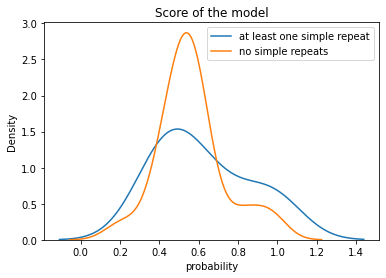

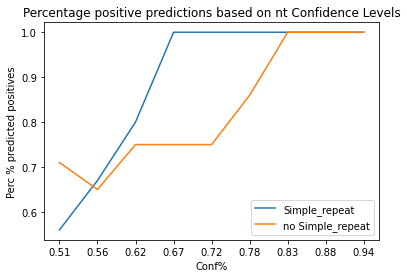

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.24932249322493225
P-value: 0.6570875533445568

Test di Mann-Whitney U:
Statistiche U: 196.0
P-value: 0.7811890699495541


In [101]:
order = 'nt'

assert order in ['nt', 'intarna', 'ensemble']

if order == 'nt':
    x, y = sr['probability'], no_sr['probability']
elif order == 'intarna':
    x, y = abs(sr['E_norm']), abs(no_sr['E_norm'])
elif order == 'ensemble':
    x, y = abs(sr['ensemble_score']), abs(no_sr['ensemble_score'])

if both_sr:
    label = f'both {feature_to_search}'
else:
    label = f'at least {feature_to_search}'
    
sns.kdeplot(x, common_norm=True, label = label if both_sr else 'at least one simple repeat')
sns.kdeplot(y, common_norm=True,  label = 'no simple repeats')

plt.title(f'Score of the model')
plt.legend()
plt.show()

conf_space1, perc_1_sr = collect_results_based_on_confidence_level_how_many1(sr, how = order, MIN_PERC = MIN_PERC, balance = False, n_values = 10, space = 'linear', intarna_treshold = intarna_treshold)
conf_space2, perc_1_nosr = collect_results_based_on_confidence_level_how_many1(no_sr, how = order, MIN_PERC = MIN_PERC, balance = False, n_values = 10, space = 'linear', intarna_treshold = intarna_treshold)

set_comuni = set(conf_space1) & set(conf_space2)

conf_space = [conf_space1[i] for i in range(len(conf_space1)) if conf_space1[i] in set_comuni]
perc_1_sr = [perc_1_sr[i] for i in range(len(conf_space1)) if conf_space1[i] in set_comuni]
perc_1_nosr = [perc_1_nosr[i] for i in range(len(conf_space2)) if conf_space2[i] in set_comuni]

plt.plot(conf_space, perc_1_sr, label = feature_to_search)
plt.plot(conf_space, perc_1_nosr, label = f'no {feature_to_search}')
plt.title(f'Percentage positive predictions based on {order} Confidence Levels')
plt.legend()
plt.ylabel('Perc % predicted positives')
plt.xlabel(f"Conf%")
plt.show()

# Test di Kolmogorov-Smirnov
ks_statistic, ks_p_value = stats.ks_2samp(x, y)
print(f"Test di Kolmogorov-Smirnov:\nStatistiche KS: {ks_statistic}\nP-value: {ks_p_value}\n")

# Test di Mann-Whitney U
mwu_statistic, mwu_p_value = stats.mannwhitneyu(x, y, alternative='two-sided')
print(f"Test di Mann-Whitney U:\nStatistiche U: {mwu_statistic}\nP-value: {mwu_p_value}")

In [41]:
if how == 'splash':
    df_repeats = pd.read_csv(os.path.join(processed_files_dir, 'nt_data', 'mean_embeddings', 'df_repeats_splash.csv'))
elif how in ['mario', 'ricseq']:
    df_repeats = pd.read_csv(os.path.join(processed_files_dir, 'nt_data', 'mean_embeddings', 'df_repeats.csv'))

#check to assert that all our repeats are correctly annotated
to_check = sr[(sr.simple_repeat1 == True) & (sr.simple_repeat2 == True) ]

for _, row in to_check.iterrows():

    if len(test500[test500.couples == row.id_sample]) == 1:
        row_test500 = test500[test500.couples == row.id_sample].iloc[0]
        subset_rep = df_repeats[df_repeats.gene_id == row.gene1_original]

        found1 = False
        for _, s_row in subset_rep.iterrows():
            if len(set(range(s_row.start, s_row.end)).intersection(set(range(row_test500['x1'] - 1, row_test500['x2'] + 1)))) > 0:
                found1 = True

        assert found1 == True

        subset_rep = df_repeats[df_repeats.gene_id == row.gene2_original]
        found2 = False
        for _, s_row in subset_rep.iterrows():
            if len(set(range(s_row.start, s_row.end)).intersection(set(range(row_test500['y1'] - 1, row_test500['y2'] + 1))))>0:
                found2 = True

        assert found2 == True

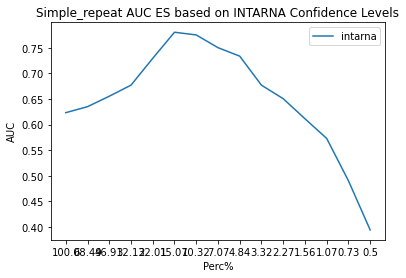

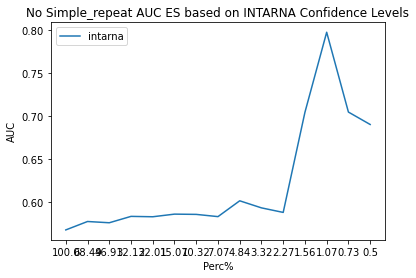

In [42]:
# AUC easypossmartneg
both_sr = False

filtered_policies = ['smartneg', 'easypos']

if both_sr:
    sr = res[res['simple_repeat1'] & res['simple_repeat2']]
else:
    sr = res[res['simple_repeat1'] | res['simple_repeat2']]

no_sr = res[(res['simple_repeat1'] == False) & (res['simple_repeat2'] == False)] #res[res['none1'] & res['none2']] #res[(res['simple_repeat1'] == False) & (res['simple_repeat2'] == False)]

sr = sr[sr.policy.isin(filtered_policies)].reset_index(drop = True)
no_sr = no_sr[no_sr.policy.isin(filtered_policies)].reset_index(drop = True)

confidence_level, auc_nt, auc_intarna, auc_ens = collect_results_based_on_confidence_level(sr, how = 'intarna', MIN_PERC = MIN_PERC, balance = False, n_values = n_values, space = 'log')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
# plt.plot(confidence_level, auc_nt, label = 'nt')
# plt.plot(confidence_level, auc_ens, label = 'ensemble')
plt.title(f'{feature_to_search} AUC ES based on INTARNA Confidence Levels')
plt.legend()
plt.ylabel('AUC')
plt.xlabel(f"Perc%")
plt.show()


confidence_level, auc_nt, auc_intarna, auc_ens = collect_results_based_on_confidence_level(no_sr, how = 'intarna', MIN_PERC = MIN_PERC, balance = False, n_values = n_values, space = 'log')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
# plt.plot(confidence_level, auc_nt, label = 'nt')
# plt.plot(confidence_level, auc_ens, label = 'ensemble')
plt.title(f'No {feature_to_search} AUC ES based on INTARNA Confidence Levels')
plt.legend()
plt.ylabel('AUC')
plt.xlabel(f"Perc%")
plt.show()

# XAI

In [97]:
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt_{how}.csv'))

DEVICE = 'cpu'

args_path = os.path.join(checkpoint_dir, 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)

# Convert the dictionary to an argparse.Namespace object
args = argparse.Namespace(**args_dict)
args.resume = os.path.join(checkpoint_dir, 'best_model.pth') # best_model

device = torch.device(DEVICE)
model = build_model(args)

checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'])

model.to(device)
model.eval()

/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


BinaryClassifierNT2(
  (nt_projection_module): NTProjectionModule(
    (conv1d): Conv1d(2560, 0, kernel_size=(1,), stride=(1,))
    (bn): BatchNorm1d(2560, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (top_classifier): MLP(
    (input_layer): Sequential(
      (0): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=5120, out_features=512, bias=True)
    )
    (hidden_layers): ModuleList()
    (output_layer): Linear(in_features=512, out_features=800, bias=True)
    (activation_functions): ModuleList(
      (0): Tanh()
    )
    (dropout_layers): ModuleList(
      (0): Dropout(p=0.01, inplace=False)
    )
  )
  (small_cnn): SmallCNN(
    (conv1): Conv2d(800, 300, kernel_size=(2, 2), stride=(1, 1))
    (conv2): Conv2d(300, 300, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU()
    (maxpool2d): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (tanh): Tanh()
    (global_avg_pool): AdaptiveAvgPool2d(

In [98]:
xai = pd.read_csv(os.path.join(checkpoint_dir, f'gradcam_results_{how}500.csv'))
xai = xai.merge(res.filter([
    'couples', 'gene1_pc', 'gene2_pc', 'original_length1', 'original_length2', 'id_sample', 'g1', 'g2', 'gene1_original', 'gene2_original'
], axis = 1), left_on = 'id', right_on = 'id_sample')

In [99]:
gradcam_results = xai[xai.probability>0.5]

iou_value: 0.0293
iou_value_tr: 0.0269
iou_value_rand: 0.0177


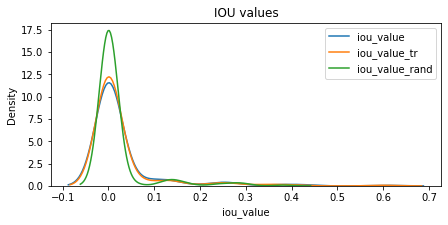

intensity: 0.4433
intensity_tr: 0.1598
intensity_rand: 0.4999


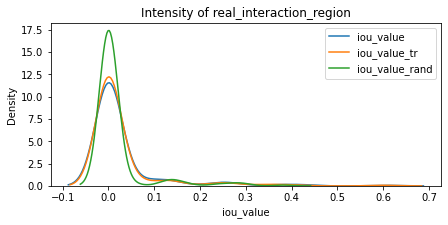

euclidean: 0.4676
euclidean_rand: 0.5099
euclidean_bbox_tr: 0.4664


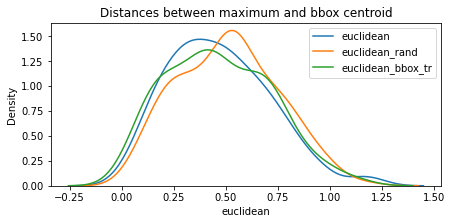

cos_sim: 0.15
cos_sim_tr: 0.09
cos_sim_rand: 0.13


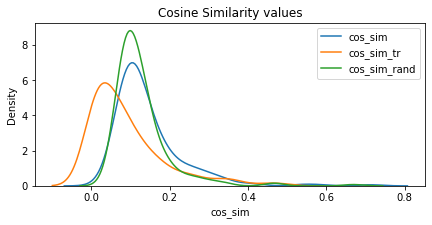

In [100]:
iou_columns = ['iou_value', 'iou_value_tr', 'iou_value_rand']
for c in iou_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in iou_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'IOU values')
plt.legend()
plt.show()

intensity_columns = ['intensity', 'intensity_tr', 'intensity_rand']
for c in intensity_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in iou_columns:
    sns.kdeplot(gradcam_results[c], label = c)
    
plt.title(f'Intensity of real_interaction_region')
plt.legend()
plt.show()

euclidean_columns = ['euclidean', 'euclidean_rand', 'euclidean_bbox_tr']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid')
plt.legend()
plt.show()

cosine_sim_columns = ['cos_sim', 'cos_sim_tr', 'cos_sim_rand']
for c in cosine_sim_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 2))}')

for c in cosine_sim_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Cosine Similarity values')
plt.legend()
plt.show()

#### Subset XAI results

euclidean: 0.4676
euclidean_rand: 0.5099


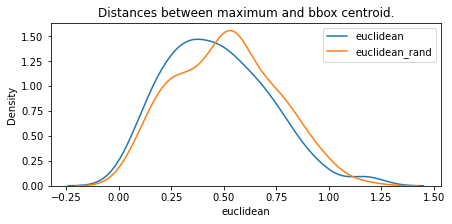

In [101]:
gradcam_results = gradcam_results[(gradcam_results.probability>0.5)]

euclidean_columns = ['euclidean', 'euclidean_rand']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid.')
plt.legend()
plt.show()

In [102]:
def plot_query_results(query):
    for _, row in query.iterrows():
        x1_emb, x2_emb, y1_emb, y2_emb = int(np.round(row.x1/6)), int(np.round(row.x2/6)), int(np.round(row.y1/6)), int(np.round(row.y2/6))
        
        embedding1_path = os.path.join(embedding_dir, '32', row.gene1+'.npy')
        embedding2_path = os.path.join(embedding_dir, '32', row.gene2+'.npy')

        embedding1 = np.load(embedding1_path)[x1_emb:x2_emb :]
        embedding2 = np.load(embedding2_path)[y1_emb:y2_emb, :]

        rna1, rna2 = torch.as_tensor(embedding1).unsqueeze(0), torch.as_tensor(embedding2).unsqueeze(0)
        rna1, rna2 = torch.transpose(rna1, 1, 2), torch.transpose(rna2, 1, 2)

        rna1, rna2 = rna1.to(device), rna2.to(device)
        
        outputs = model(rna1, rna2)

        outputs[:, 1].backward()
        #print('prob:', outputs.softmax(-1)[:, 1])
        #print('degree:', row.abs_sum_diff)
        x1 = int(row.seed_x1-row.x1)
        x2 = int(row.seed_x2-row.x1)
        y1 = int(row.seed_y1-row.y1)
        y2 = int(row.seed_y2-row.y1)
        width = row.len1
        height = row.len2
        

        expl_matrix = gradcam(model, rna1, rna2, counterfactual = False, cnn_layer = 2)
        
        expl_matrix_reshaped = interpolate_expl_matrix(expl_matrix, height=height, width=width)
        
        # print(x1, x2, y1, y2)
        # print(expl_matrix_reshaped.shape)

        scaling_factor = 70

        plot_matrix(expl_matrix_reshaped, 
        [[y1, x1, y2-y1, x2-x1]], #crop_bbox =[x1hat, y1hat, what, hhat], 
        cmap ='viridis', 
        scaling_factor = scaling_factor)
        plt.show()

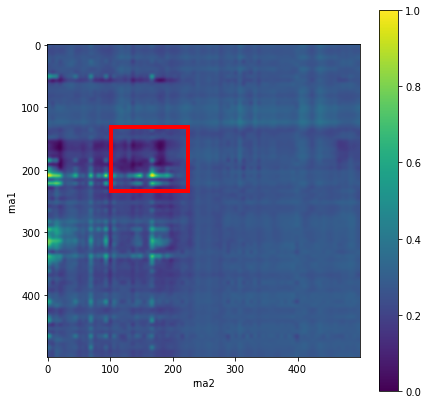

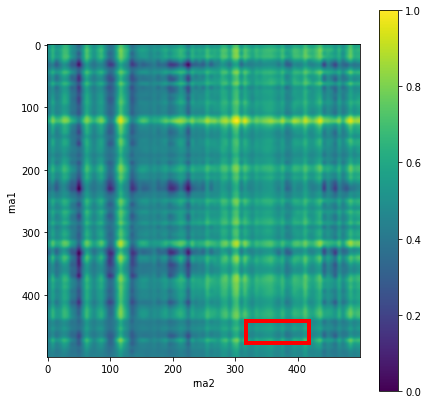

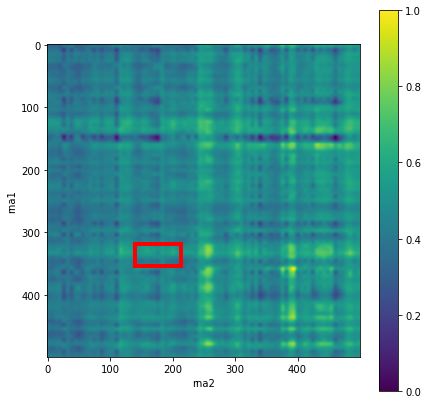

In [ ]:
N_plots = max(10, gradcam_results.shape[0])
query = test500[test500.couples.isin(list(gradcam_results.sample(N_plots).id))]
plot_query_results(query)

euclidean: 0.4825
euclidean_rand: 0.7092


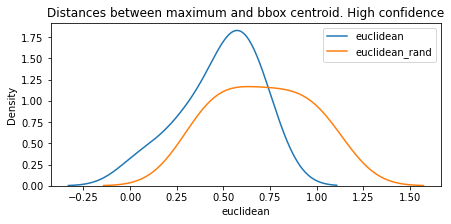

In [52]:
n_best = 10

gradcam_results = xai.sort_values('probability').tail(n_best)
#gradcam_results = xai.sort_values('iou_value').tail(n_best)
#gradcam_results = xai[(xai.probability>0.6)&(xai.probability<0.77)].sample(n_best)

euclidean_columns = ['euclidean', 'euclidean_rand']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid. High confidence')
plt.legend()
plt.show()

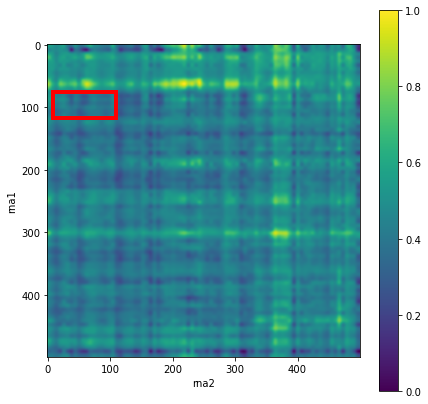

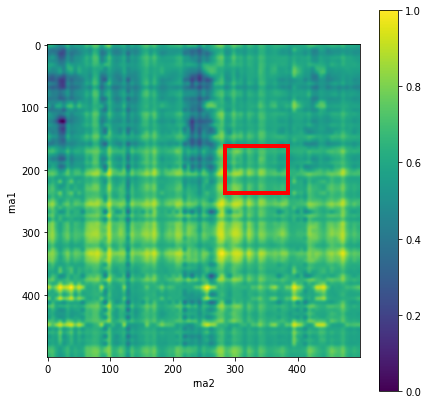

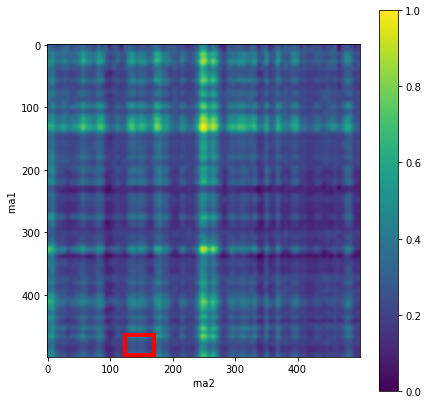

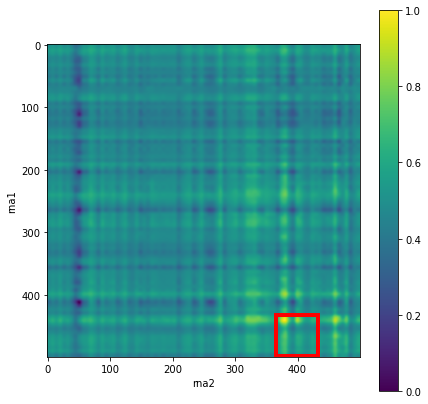

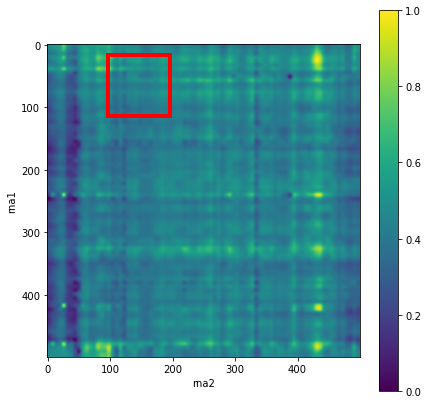

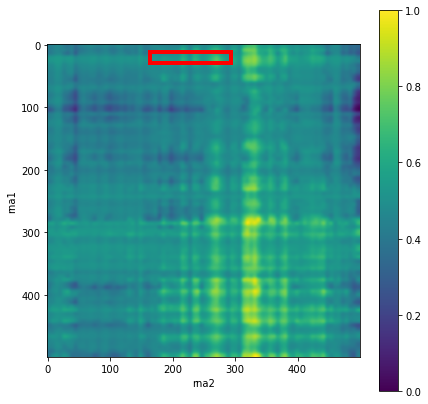

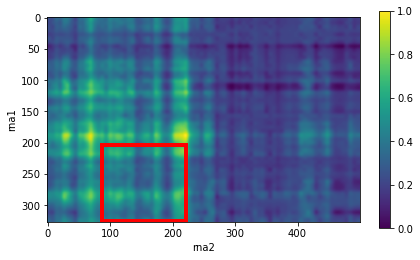

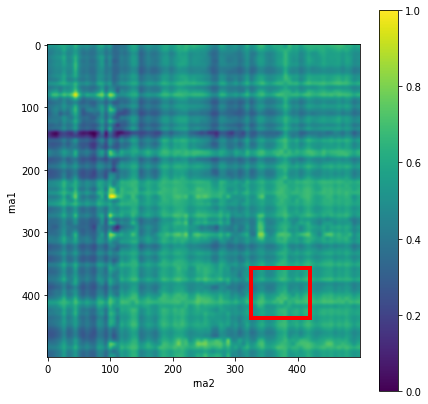

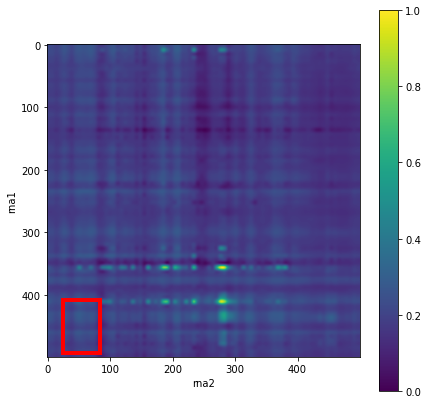

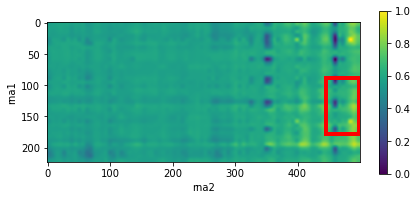

In [53]:
query = test500[test500.couples.isin(list(gradcam_results.id))]
plot_query_results(query)